# Reverse-engineering GPT2-small

# Setup

## Dependencies

In [1]:
import transformer_lens
from transformer_lens import HookedTransformer, utils
import ipywidgets
import torch
import numpy as np
import pprint
import json
import torch.nn as nn
import torch.nn.functional as F
from datasets import load_dataset
from huggingface_hub import HfApi
from IPython.display import HTML
from functools import partial
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'stix'

/gpfs/gibbs/project/cohan/jhd43/conda_envs/nlp_env/lib/python3.9/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/gpfs/gibbs/project/cohan/jhd43/conda_envs/nlp_env/lib/python3.9/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


## Load model

In [2]:
from sae_training.sparse_autoencoder import SparseAutoencoder
from sae_training.utils import LMSparseAutoencoderSessionloader

In [3]:
model = HookedTransformer.from_pretrained('gpt2')

/gpfs/gibbs/project/cohan/jhd43/conda_envs/nlp_env/lib/python3.9/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
Using pad_token, but it is not set yet.


Loaded pretrained model gpt2 into HookedTransformer


## Loading data

In [4]:
import einops
def tokenize_and_concatenate(
    dataset,
    tokenizer,
    streaming = False,
    max_length = 1024,
    column_name = "text",
    add_bos_token = True,
):
    """Helper function to tokenizer and concatenate a dataset of text. This converts the text to tokens, concatenates them (separated by EOS tokens) and then reshapes them into a 2D array of shape (____, sequence_length), dropping the last batch. Tokenizers are much faster if parallelised, so we chop the string into 20, feed it into the tokenizer, in parallel with padding, then remove padding at the end.

    This tokenization is useful for training language models, as it allows us to efficiently train on a large corpus of text of varying lengths (without, eg, a lot of truncation or padding). Further, for models with absolute positional encodings, this avoids privileging early tokens (eg, news articles often begin with CNN, and models may learn to use early positional encodings to predict these)

    Args:
        dataset (Dataset): The dataset to tokenize, assumed to be a HuggingFace text dataset.
        tokenizer (AutoTokenizer): The tokenizer. Assumed to have a bos_token_id and an eos_token_id.
        streaming (bool, optional): Whether the dataset is being streamed. If True, avoids using parallelism. Defaults to False.
        max_length (int, optional): The length of the context window of the sequence. Defaults to 1024.
        column_name (str, optional): The name of the text column in the dataset. Defaults to 'text'.
        add_bos_token (bool, optional): . Defaults to True.

    Returns:
        Dataset: Returns the tokenized dataset, as a dataset of tensors, with a single column called "tokens"

    Note: There is a bug when inputting very small datasets (eg, <1 batch per process) where it just outputs nothing. I'm not super sure why
    """
    for key in dataset.features:
        if key != column_name:
            dataset = dataset.remove_columns(key)

    if tokenizer.pad_token is None:
        # We add a padding token, purely to implement the tokenizer. This will be removed before inputting tokens to the model, so we do not need to increment d_vocab in the model.
        tokenizer.add_special_tokens({"pad_token": "<PAD>"})
    # Define the length to chop things up into - leaving space for a bos_token if required
    if add_bos_token:
        seq_len = max_length - 1
    else:
        seq_len = max_length

    def tokenize_function(examples):
        text = examples[column_name]
        # Concatenate it all into an enormous string, separated by eos_tokens
        full_text = tokenizer.eos_token.join(text)
        # Divide into 20 chunks of ~ equal length
        num_chunks = 20
        chunk_length = (len(full_text) - 1) // num_chunks + 1
        chunks = [
            full_text[i * chunk_length : (i + 1) * chunk_length]
            for i in range(num_chunks)
        ]
        # Tokenize the chunks in parallel. Uses NumPy because HuggingFace map doesn't want tensors returned
        tokens = tokenizer(chunks, return_tensors="np", padding=True)[
            "input_ids"
        ].flatten()
        # Drop padding tokens
        tokens = tokens[tokens != tokenizer.pad_token_id]
        num_tokens = len(tokens)
        num_batches = num_tokens // (seq_len)
        # Drop the final tokens if not enough to make a full sequence
        tokens = tokens[: seq_len * num_batches]
        tokens = einops.rearrange(
            tokens, "(batch seq) -> batch seq", batch=num_batches, seq=seq_len
        )
        if add_bos_token:
            prefix = np.full((num_batches, 1), tokenizer.bos_token_id)
            tokens = np.concatenate([prefix, tokens], axis=1)
        return {"tokens": tokens}

    tokenized_dataset = dataset.map(
        tokenize_function,
        batched=True,
        remove_columns=[column_name],
    )
    #tokenized_dataset.set_format(type="torch", columns=["tokens"])
    return tokenized_dataset


In [5]:
dataset = load_dataset('Skylion007/openwebtext', split='train', streaming=True)
dataset = dataset.shuffle(seed=42, buffer_size=10_000)
tokenized_owt = tokenize_and_concatenate(dataset, model.tokenizer, max_length=128, streaming=True)
tokenized_owt = tokenized_owt.shuffle(42)
tokenized_owt = tokenized_owt.take(12800*2)
owt_tokens = np.stack([x['tokens'] for x in tokenized_owt])

Token indices sequence length is longer than the specified maximum sequence length for this model (73252 > 1024). Running this sequence through the model will result in indexing errors


In [6]:
owt_tokens_torch = torch.from_numpy(owt_tokens).cuda()

## Feature scores

In [7]:
def get_feature_scores(model, encoder, tokens_arr, feature_idx, batch_size=64, act_name='resid_pre', layer=0, use_raw_scores=False, use_decoder=False, feature_post=None, ignore_endoftext=False):
  act_name = encoder.cfg.hook_point
  layer = encoder.cfg.hook_point_layer
    
  scores = []
  endoftext_token = model.tokenizer.eos_token 
  for i in tqdm.tqdm(range(0, tokens_arr.shape[0], batch_size)):
    #print(i, tokens_arr.shape[0], batch_size)
    with torch.no_grad():
      _, cache = model.run_with_cache(tokens_arr[i:i+batch_size], stop_at_layer=layer+1, names_filter=[
        act_name#utils.get_act_name(act_name, layer)
      ])
      mlp_acts = cache[act_name]#utils.get_act_name(act_name, layer)]
      mlp_acts_flattened = mlp_acts.reshape(-1, encoder.W_enc.shape[0])
      if feature_post is None:
        feature_post = encoder.W_enc[:, feature_idx] if not use_decoder else encoder.W_dec[feature_idx]
      bias = -(encoder.b_dec @ feature_post) if use_decoder else encoder.b_enc[feature_idx] - (encoder.b_dec @ feature_post)
      if use_raw_scores:
        cur_scores = (mlp_acts_flattened @ feature_post) + bias
      else:
        _, hidden_acts, _, _, _, _ = encoder(mlp_acts_flattened)
        cur_scores = hidden_acts[:, feature_idx]
      if ignore_endoftext:
          cur_scores[tokens_arr[i:i+batch_size].reshape(-1) == endoftext_token] = -torch.inf
    scores.append(utils.to_numpy(cur_scores.reshape(-1, tokens_arr.shape[1])).astype(np.float16))
  return np.concatenate(scores)

In [8]:
def sample_percentiles(arr, num_samples):
    sample_idxs = []
    sample_vals = []
    
    num_samples = num_samples - 1
    p_step = 100./num_samples
    
    for p in np.arange(0,100,p_step):
        value_at_p = np.percentile(arr.reshape(-1), p, interpolation='nearest')
        p_idx = np.abs(arr-value_at_p).argmin()
        
        sample_vals.append(value_at_p)
        sample_idxs.append(np.unravel_index(p_idx, arr.shape))

    # get maximum
    value_at_p = np.max(arr)
    p_idx = np.abs(arr-value_at_p).argmin()

    sample_vals.append(value_at_p)
    sample_idxs.append(np.unravel_index(p_idx, arr.shape))
    
    return np.array(sample_vals), np.array(sample_idxs)

In [9]:
def sample_uniform(arr, num_samples, unique=True, use_tqdm=False, only_max_range=False):
    sample_idxs = []
    sample_vals = []

    max_val = np.max(arr)
    if not only_max_range:
        min_val = np.min(arr)
    else:
        min_val = -max_val

    num_samples = num_samples - 1
    p_step = 1./num_samples

    func = (lambda x: x) if not use_tqdm else (lambda x: tqdm.tqdm(x))
    
    for p in func(np.arange(0,1,p_step)):
        value_at_p = min_val + p * (max_val - min_val)
        p_idx = np.abs(arr-value_at_p).argmin()
        real_val = arr[np.unravel_index(p_idx, arr.shape)]
        sample_vals.append(real_val)
        sample_idxs.append(np.unravel_index(p_idx, arr.shape))

    # get maximum
    value_at_p = np.max(arr)
    p_idx = np.abs(arr-value_at_p).argmin()

    sample_vals.append(value_at_p)
    sample_idxs.append(np.unravel_index(p_idx, arr.shape))

    sample_vals = np.array(sample_vals)
    sample_idxs = np.array(sample_idxs)

    if unique:
        sample_vals, sample_pos = np.unique(sample_vals, return_index=True)
        sample_idxs = sample_idxs[sample_pos]
    
    return sample_vals, sample_idxs

## Feature dashboards

In [10]:
def get_percent_between_scores_vec(scores, num_bands, return_percentages=True):
    scores_max = scores.max()
    scores_min = scores.min()

    retlist = []
    denom = 1 if not return_percentages else np.prod(scores.shape)
    for band_idx in range(num_bands):
        low_score = scores_min + (scores_max-scores_min)*band_idx/num_bands
        high_score = scores_min + (scores_max-scores_min)*(band_idx+1)/num_bands
        #print(low_score, high_score)
        retlist.append(np.sum(np.logical_and(
            scores >= low_score, scores <= high_score
        ))/denom)
    return np.array(retlist)

In [11]:
import html

def make_sequence_html(token_strs, scores,
    scores_min=None,
    scores_max=None,
    max_color='#ff8c00',
    zero_color='#ffffff',
    return_head=False,
    cur_token_idx=None,
    window_size=None,
):
    if scores_min is None: scores_min = scores.min()
    if scores_max is None: scores_max = scores.max()
    scores_normalized = (scores-scores_min)/(scores_max-scores_min)

    if window_size is not None:
        left_idx = np.max([0, cur_token_idx-window_size])
        right_idx = np.min([len(scores), cur_token_idx+window_size])
        scores = scores[left_idx:right_idx]
        scores_normalized = scores_normalized[left_idx:right_idx]
        token_strs = token_strs[left_idx:right_idx]
        cur_token_idx = cur_token_idx - left_idx

    max_color_vec = np.array([int(max_color[1:3], 16), int(max_color[3:5], 16), int(max_color[5:7], 16)])
    zero_color_vec = np.array([int(zero_color[1:3], 16), int(zero_color[3:5], 16), int(zero_color[5:7], 16)])

    color_vecs = np.einsum('i, j -> ij', scores_normalized, max_color_vec) + np.einsum('i, j -> ij', 1-scores_normalized, zero_color_vec)
    color_strs = [f"#{int(x[0]):02x}{int(x[1]):02x}{int(x[2]):02x}" for x in color_vecs]

    tokens_html = "".join([
        f"""<span class='token'
            style='background-color: {color_strs[i]}'
            onMouseOver='showTooltip(this)'
            onMouseOut='hideTooltip(this)'>{"<b>" if cur_token_idx is not None and i == cur_token_idx else ""}{html.escape(token_str)}{"</b>" if cur_token_idx is not None and i == cur_token_idx else ""}<span class='feature_val'> ({scores[i]:.2f})</span></span>"""
         for i, token_str in enumerate(token_strs)
    ])

    if return_head:
        head = """
<script>
    function showTooltip(element) {
        feature_val = element.querySelector('.feature_val')
        feature_val.style.display='inline'
    }

    function hideTooltip(element) {
        feature_val = element.querySelector('.feature_val')
        feature_val.style.display='none'
    }
</script>
<style>
    span.token {
        font-family: monospace;
        
        border-style: solid;
        border-width: 1px;
        border-color: #dddddd;
    }

    .feature_val {
        display: none;
        font-family: serif;
    }

    #tooltip {
        display: none;
    }
</style>
"""
        return head + tokens_html
    else:
        return tokens_html

def get_uniform_band_examples(scores, uniform_vals, uniform_idxs, num_bands, band_size, return_percentages=False):
    retlist = []
    
    total_num_exs = num_bands*band_size
    scores_min = scores.min() 
    scores_max = scores.max()
    bandwidth = (scores_max-scores_min)/total_num_exs
    denom = 1 if not return_percentages else np.prod(scores.shape)

    for band in range(0, total_num_exs+band_size, band_size):
        #print(band)
        low_score = scores_min + band*bandwidth
        high_score = scores_min + (band+band_size)*bandwidth
        num_examples_in_band = np.sum(np.logical_and(
            scores >= low_score, scores <= high_score
        ))/denom
        retlist.append((low_score, high_score, num_examples_in_band, uniform_idxs[np.logical_and(uniform_vals>=low_score, uniform_vals<=high_score)]))
    return retlist

def display_activating_examples_dash(all_tokens, scores,
     num_examples=50,
     num_bands=5,
     bandwidth=10,
     return_percentages=True,
     window_size=5,
     header_level=3
    ):
    if type(header_level) is int:
        header_tag = f'h{header_level}'
    else:
        header_tag = 'p'

    display(HTML(f"<{header_tag} style='font-family: serif'>Sparsity: {100*np.sum(scores > 0)/np.prod(scores.shape):.4f}%</{header_tag}>"))
    uniform_vals, uniform_idxs = sample_uniform(scores, num_examples, unique=True)
    unif_bands = get_uniform_band_examples(scores, uniform_vals, uniform_idxs, num_bands, bandwidth, return_percentages=return_percentages)
    for band in reversed(unif_bands):
        cur_html_list = [f"<details><summary><{header_tag} style='display: inline; font-family: serif'>Between {band[0]:.2f} and {band[1]:.2f}: {100*band[2]:.4f}%</{header_tag}></summary>"]
        for example_idx, token_idx in band[3]:
            cur_html_list.append(
                make_sequence_html(
                    model.to_str_tokens(all_tokens[example_idx]), scores[example_idx],
                    scores_min=scores.min(), scores_max=scores.max(), return_head=True, cur_token_idx=token_idx, window_size=window_size
                ) + f"<span> Example {example_idx}, token {token_idx}</span>" + "<br/>"
            )
        cur_html_list.append("</details>")
        display(HTML("".join(cur_html_list)))

def get_logits_for_feature(model, sae, feature_idx, k=7):
    feature = sae.W_dec[feature_idx]

    with torch.no_grad():
        most_pos = torch.topk(feature @ model.W_U, k=k)
        most_neg = torch.topk(-feature @ model.W_U, k=k)
    
    top_vals = utils.to_numpy(most_pos.values)
    top_idxs = utils.to_numpy(most_pos.indices)
    top_tokens = model.to_str_tokens(top_idxs)
    
    bot_vals = utils.to_numpy(-most_neg.values)
    bot_idxs = utils.to_numpy(most_neg.indices)
    bot_tokens = model.to_str_tokens(bot_idxs)

    return zip(top_vals, top_tokens, bot_vals, bot_tokens)
    
def batch_color_interpolate(scores, max_color, zero_color, scores_min=None, scores_max=None):
    if scores_min is None: scores_min = scores.min()
    if scores_max is None: scores_max = scores.max()
    scores_normalized = (scores - scores_min) / (scores_max - scores_min)
    
    max_color_vec = np.array([int(max_color[1:3], 16), int(max_color[3:5], 16), int(max_color[5:7], 16)])
    zero_color_vec = np.array([int(zero_color[1:3], 16), int(zero_color[3:5], 16), int(zero_color[5:7], 16)])

    color_vecs = np.einsum('i, j -> ij', scores_normalized, max_color_vec) + np.einsum('i, j -> ij', 1-scores_normalized, zero_color_vec)
    color_strs = [f"#{int(x[0]):02x}{int(x[1]):02x}{int(x[2]):02x}" for x in color_vecs]
    return color_strs

def display_logits_for_feature(model, sae, feature_idx, k=7):
    logits = list(get_logits_for_feature(model, sae, feature_idx, k=k))

    table_html = """
<style>
    span.token {
        font-family: monospace;
        
        border-style: solid;
        border-width: 1px;
        border-color: #dddddd;
    }
</style>
<table>
    <thead>
        <tr>
            <th colspan=2 style='text-align:center'>Bottom logits</th>
            <th colspan=2 style='text-align:center'>Top logits</th>
        </tr>
    </thead>
    <tbody>
"""

    top_scores = np.array([x[0] for x in logits])
    bot_scores = np.array([x[2] for x in logits])
    scores_max = np.max(top_scores)
    scores_min = np.min(bot_scores)
    
    top_color_strs = batch_color_interpolate(top_scores, '#7f7fff', '#ffffff', scores_min=scores_min, scores_max=scores_max)
    bot_color_strs = batch_color_interpolate(-bot_scores, '#ff7f7f', '#ffffff', scores_min=scores_min, scores_max=scores_max)

    for i, (top_val, top_token, bot_val, bot_token) in enumerate(logits):
        row_html =\
f"""<tr>
    <td style='text-align:left'><span class='token' style='background-color: {bot_color_strs[i]}'>{html.escape(bot_token).replace(' ', '&nbsp;')}</span></td>
    <td style='text-align:right'>{bot_val:.3f}</td>
    <td style='text-align:left'><span class='token' style='background-color: {top_color_strs[i]}'>{html.escape(top_token).replace(' ', '&nbsp;')}</span></td>
    <td style='text-align:right'>+{top_val:.3f}</td>
</tr>"""
        table_html = table_html + row_html
    table_html = table_html + "</tbody></table>"
    display(HTML(table_html))

    all_logits = utils.to_numpy(sae.W_dec[feature_idx] @ model.W_U)

    fig, ax = plt.subplots()
    ax.hist(all_logits[all_logits < 0], color='#ff7f7f')
    ax.hist(all_logits[all_logits > 0], color='#7f7fff')
    fig.set_size_inches(5,2)
    plt.show()
    

In [159]:
def plot_pulledback_feature(model, feature_vector, transcoder, size=None, do_plot=True,
                            input_tokens=None, input_example=None, input_token_idx=None):
    if size is None: size=(5,3)
    with torch.no_grad():
        pulledback_feature = transcoder.W_dec @ feature_vector.vector

        if input_example is not None:
            input_layer = transcoder.cfg.hook_point_layer
            if type(input_example) is int and input_tokens is not None:
                prompt = input_tokens[input_example]
            elif type(input_example) is str:
                prompt = input_example
            # TODO: add list support
            _, cache = model.run_with_cache(prompt, stop_at_layer=input_layer+1,
                names_filter=utils.get_act_name(f'normalized{input_layer}ln2', input_layer)
            )
            feature_activs = transcoder(cache[utils.get_act_name(f'normalized{input_layer}ln2', input_layer)])[1][0,input_token_idx]
            pulledback_feature = pulledback_feature * feature_activs
            
    pulledback_feature = utils.to_numpy(pulledback_feature)

    if do_plot:
        score_max = np.max(np.abs([pulledback_feature.max(), pulledback_feature.min()]))
        score_min = -np.min(np.abs([pulledback_feature.max(), pulledback_feature.min()]))
        colors = batch_color_interpolate(pulledback_feature, '#7f7fff', '#ff7f7f')#, scores_min=score_min, scores_max=score_max)
        
        
        fig, ax = plt.subplots()
        ax.plot(pulledback_feature, alpha=0.5)
        ax.scatter(range(len(pulledback_feature)), pulledback_feature, color=colors)
        fig.set_size_inches(size[0], size[1])
        plt.xlabel("Transcoder feature index")
        plt.ylabel("Connection strength")
        if type(input_example) is int:
            plt.title(f"Example {input_example} token {input_token_idx}:\n {str(feature_vector)} from transcoder features")
        elif type(input_example) is str:
            plt.title(f"Connections on prompt:\n {str(feature_vector)} from transcoder features")
        else:
            plt.title(f"Input-independent connections:\n {str(feature_vector)} from transcoder features")
        plt.show()
    return pulledback_feature

def get_transcoder_pullback_features(model, feature_vector, transcoder, k=7, do_plot=True,
    input_tokens=None, input_example=None, input_token_idx=None
):
    pulledback_feature = plot_pulledback_feature(model, feature_vector, transcoder, do_plot=do_plot,
        input_tokens=input_tokens, input_example=input_example, input_token_idx=input_token_idx)
    pulledback_feature = torch.from_numpy(pulledback_feature)
    with torch.no_grad():
        most_pos = torch.topk(pulledback_feature, k=k)
        most_neg = torch.topk(-pulledback_feature, k=k)
    
    top_vals = utils.to_numpy(most_pos.values)
    top_idxs = utils.to_numpy(most_pos.indices)
    
    bot_vals = utils.to_numpy(-most_neg.values)
    bot_idxs = utils.to_numpy(most_neg.indices)

    return zip(top_vals, top_idxs, bot_vals, bot_idxs)

def display_transcoder_pullback_features(model, feature_vector, transcoder, k=7,
    input_tokens=None, input_example=None, input_token_idx=None
):
    logits = list(get_transcoder_pullback_features(model, feature_vector, transcoder, k=k,
        input_tokens=input_tokens, input_example=input_example, input_token_idx=input_token_idx)
    )

    table_html = """
<style>
    span.token {
        font-family: monospace;
        
        border-style: solid;
        border-width: 1px;
        border-color: #dddddd;
    }
</style>
<table>
    <thead>
        <tr>
            <th colspan=2 style='text-align:center'>Most-negative transcoder features</th>
            <th colspan=2 style='text-align:center'>Most-positive transcoder features</th>
        </tr>
    </thead>
    <tbody>
"""

    top_scores = np.array([x[0] for x in logits])
    bot_scores = np.array([x[2] for x in logits])
    scores_max = np.max(top_scores)
    scores_min = np.min(bot_scores)
    
    top_color_strs = batch_color_interpolate(top_scores, '#7f7fff', '#ffffff', scores_min=scores_min, scores_max=scores_max)
    bot_color_strs = batch_color_interpolate(-bot_scores, '#ff7f7f', '#ffffff', scores_min=scores_min, scores_max=scores_max)

    for i, (top_val, top_idx, bot_val, bot_idx) in enumerate(logits):
        row_html =\
f"""<tr>
    <td style='text-align:left'><span class='token' style='background-color: {bot_color_strs[i]}'>{bot_idx}</span></td>
    <td style='text-align:right'>{bot_val:.3f}</td>
    <td style='text-align:left'><span class='token' style='background-color: {top_color_strs[i]}'>{top_idx}</span></td>
    <td style='text-align:right'>+{top_val:.3f}</td>
</tr>"""
        table_html = table_html + row_html
    table_html = table_html + "</tbody></table>"
    display(HTML(table_html))

In [13]:
def get_ov_norms_for_transcoder_feature(model, transcoder, feature_idx, layer=None):
    with torch.no_grad():
        propagated_vecs = torch.einsum('lhio,o->lhi', model.OV.AB, transcoder.W_enc[:, feature_idx])
        if layer is not None:
            propagated_vecs = propagated_vecs[:layer+1]
        ov_norms = propagated_vecs.norm(dim=-1)
        
        fig, ax = plt.subplots()
        mat = ax.matshow(utils.to_numpy(ov_norms), cmap='Reds', vmin=0)
        fig.colorbar(mat, location="bottom")
        ax.set_yticks(range(ov_norms.shape[0]))
        ax.set_xlabel("Attention head")
        ax.set_ylabel("Layer")
        fig.set_size_inches(5,3)
        ax.set_title(f"OV de-embedding norms for transcoder feature {feature_idx}", fontsize=10)
        plt.show()

    return ov_norms

def get_deembeddings_for_transcoder_feature(model, transcoder, feature_idx, attn_head=None, attn_layer=0, k=7):
    with torch.no_grad():
        if attn_head is not None:
            pulledback_feature = model.W_E @ model.OV.AB[attn_layer, attn_head] @ transcoder.W_enc[:, feature_idx]
        else:
            pulledback_feature = model.W_E @ transcoder.W_enc[:, feature_idx]
        if k == 0:
            return utils.to_numpy(pulledback_feature)
        else:
            most_pos = torch.topk(pulledback_feature, k=k)
            most_neg = torch.topk(-pulledback_feature, k=k)
    
            top_vals = utils.to_numpy(most_pos.values)
            top_idxs = utils.to_numpy(most_pos.indices)
            top_tokens = model.to_str_tokens(top_idxs)
            
            bot_vals = utils.to_numpy(-most_neg.values)
            bot_idxs = utils.to_numpy(most_neg.indices)
            bot_tokens = model.to_str_tokens(bot_idxs)

            return utils.to_numpy(pulledback_feature), zip(top_vals, top_tokens, bot_vals, bot_tokens)

def get_deembeddings_for_feature_vector(model, feature_vector, k=7):
    with torch.no_grad():
        pulledback_feature = model.W_E @ feature_vector.vector
        if k == 0:
            return utils.to_numpy(pulledback_feature)
        else:
            most_pos = torch.topk(pulledback_feature, k=k)
            most_neg = torch.topk(-pulledback_feature, k=k)
    
            top_vals = utils.to_numpy(most_pos.values)
            top_idxs = utils.to_numpy(most_pos.indices)
            top_tokens = model.to_str_tokens(top_idxs)
            
            bot_vals = utils.to_numpy(-most_neg.values)
            bot_idxs = utils.to_numpy(most_neg.indices)
            bot_tokens = model.to_str_tokens(bot_idxs)

            return utils.to_numpy(pulledback_feature), zip(top_vals, top_tokens, bot_vals, bot_tokens)

def plot_deembedding_for_transcoder_feature(model, transcoder, feature_idx, attn_head=None, attn_layer=0):
    pulledback_feature = get_deembeddings_for_transcoder_feature(model, transcoder, feature_idx, attn_head=attn_head, attn_layer=attn_layer, k=0)
    
    score_max = np.max(np.abs([pulledback_feature.max(), pulledback_feature.min()]))
    score_min = -np.min(np.abs([pulledback_feature.max(), pulledback_feature.min()]))
    colors = batch_color_interpolate(pulledback_feature, '#7f7fff', '#ff7f7f')#, scores_min=score_min, scores_max=score_max)
    
    fig, ax = plt.subplots()
    ax.plot(pulledback_feature, alpha=0.5)
    ax.scatter(range(len(pulledback_feature)), pulledback_feature, color=colors)
    fig.set_size_inches(4,2)
    plt.xlabel("Token index")
    plt.ylabel("Connection strength")
    plt.show()

def display_deembeddings_for_transcoder_feature(model, transcoder, feature_idx, attn_head=None, attn_layer=0, k=7):
    pulledback_feature, deembeddings = get_deembeddings_for_transcoder_feature(model, transcoder, feature_idx, attn_head=attn_head, attn_layer=attn_layer, k=k)
    deembeddings = list(deembeddings)

    table_html = """
<style>
    span.token {
        font-family: monospace;
        
        border-style: solid;
        border-width: 1px;
        border-color: #dddddd;
    }
</style>"""f"""
<b>{"Direct path" if attn_head is None else f"Attention head {attn_head}"}</b>
<table>
    <thead>
        <tr>
            <th colspan=2 style='text-align:center'>Most-negative de-embedding tokens</th>
            <th colspan=2 style='text-align:center'>Most-positive de-embedding tokens</th>
        </tr>
    </thead>
    <tbody>
"""

    top_scores = np.array([x[0] for x in deembeddings])
    bot_scores = np.array([x[2] for x in deembeddings])
    scores_max = np.max(top_scores)
    scores_min = np.min(bot_scores)
    
    top_color_strs = batch_color_interpolate(top_scores, '#7f7fff', '#ffffff', scores_min=scores_min, scores_max=scores_max)
    bot_color_strs = batch_color_interpolate(-bot_scores, '#ff7f7f', '#ffffff', scores_min=scores_min, scores_max=scores_max)

    for i, (top_val, top_token, bot_val, bot_token) in enumerate(deembeddings):
        row_html =\
f"""<tr>
    <td style='text-align:left'><span class='token' style='background-color: {bot_color_strs[i]}'>{html.escape(bot_token).replace(" ", "&nbsp;")}</span></td>
    <td style='text-align:right'>{bot_val:.3f}</td>
    <td style='text-align:left'><span class='token' style='background-color: {top_color_strs[i]}'>{html.escape(top_token).replace(" ", "&nbsp;")}</span></td>
    <td style='text-align:right'>+{top_val:.3f}</td>
</tr>"""
        table_html = table_html + row_html
    table_html = table_html + "</tbody></table>"
    display(HTML(table_html))

def display_deembeddings_for_feature_vector(model, feature_vector, k=7):
    pulledback_feature, deembeddings = get_deembeddings_for_feature_vector(model, feature_vector, k=k)
    deembeddings = list(deembeddings)

    table_html = """
<style>
    span.token {
        font-family: monospace;
        
        border-style: solid;
        border-width: 1px;
        border-color: #dddddd;
    }
</style>"""f"""
<b>{str(feature_vector)}</b>
<table>
    <thead>
        <tr>
            <th colspan=2 style='text-align:center'>Most-negative de-embedding tokens</th>
            <th colspan=2 style='text-align:center'>Most-positive de-embedding tokens</th>
        </tr>
    </thead>
    <tbody>
"""

    top_scores = np.array([x[0] for x in deembeddings])
    bot_scores = np.array([x[2] for x in deembeddings])
    scores_max = np.max(top_scores)
    scores_min = np.min(bot_scores)
    
    top_color_strs = batch_color_interpolate(top_scores, '#7f7fff', '#ffffff', scores_min=scores_min, scores_max=scores_max)
    bot_color_strs = batch_color_interpolate(-bot_scores, '#ff7f7f', '#ffffff', scores_min=scores_min, scores_max=scores_max)

    for i, (top_val, top_token, bot_val, bot_token) in enumerate(deembeddings):
        row_html =\
f"""<tr>
    <td style='text-align:left'><span class='token' style='background-color: {bot_color_strs[i]}'>{html.escape(bot_token).replace(" ", "&nbsp;")}</span></td>
    <td style='text-align:right'>{bot_val:.3f}</td>
    <td style='text-align:left'><span class='token' style='background-color: {top_color_strs[i]}'>{html.escape(top_token).replace(" ", "&nbsp;")}</span></td>
    <td style='text-align:right'>+{top_val:.3f}</td>
</tr>"""
        table_html = table_html + row_html
    table_html = table_html + "</tbody></table>"
    display(HTML(table_html))

def display_analysis_for_transcoder_feature(model, transcoder, feature_idx, attn_k=2, k=8, layer=None):
    display(HTML(f"<h3>Transcoder feature {feature_idx}</h3>"))
    display_deembeddings_for_transcoder_feature(model, transcoder, feature_idx, k=k)
    plot_deembedding_for_transcoder_feature(model, transcoder, feature_idx)
    
    display(HTML(f"<h4>OV circuits</h4>"))
    ov_norms = get_ov_norms_for_transcoder_feature(model, transcoder, feature_idx, layer=layer)
    top_ov_norms, top_ov_heads_flattened = torch.topk(ov_norms.flatten(), k=attn_k)
    top_ov_indices = np.array(np.unravel_index(utils.to_numpy(top_ov_heads_flattened), ov_norms.shape)).T        

    colors = batch_color_interpolate(utils.to_numpy(top_ov_norms), '#ff7f7f', '#ffffff', scores_min=0, scores_max=top_ov_norms.max().item())
    table_html = f"""<h4>Top {top_ov_indices.shape[0]} attention heads by OV circuit norm</h4>
    <table>
        <thead>
            <tr>
                <th style='text-align:center'>Layer</th>
                <th style='text-align:center'>Head</th>
                <th style='text-align:center'>Norm</th>
            </tr>
        </thead>
        <tbody>
            { "".join(f"<tr style='background-color: {color}'><td>{layer}</td><td>{head}</td><td>{norm:.2f}</td>" for (layer, head), norm, color in zip(top_ov_indices, top_ov_norms, colors))}
        </tbody>
    """
    display(HTML(table_html))

    for cur_layer, head in top_ov_indices:
        display_deembeddings_for_transcoder_feature(model, transcoder, feature_idx, attn_head=head, attn_layer=cur_layer)
        plot_deembedding_for_transcoder_feature(model, transcoder, feature_idx, attn_head=head, attn_layer=cur_layer)

## Transcoder replacement context manager

In [129]:
class TranscoderWrapper(torch.nn.Module):
    def __init__(self, transcoder):
        super().__init__()
        self.transcoder = transcoder
    def forward(self, x):
        return self.transcoder(x)[0]

class TranscoderReplacementContext:
    def __init__(self, model, transcoders):
        self.layers = [t.cfg.hook_point_layer for t in transcoders]
        self.original_mlps = [ model.blocks[i].mlp for i in self.layers ]
        
        self.transcoders = transcoders
        #self.layers = layers
        self.model = model
    
    def __enter__(self):
        for transcoder in self.transcoders:
           self.model.blocks[transcoder.cfg.hook_point_layer].mlp = TranscoderWrapper(transcoder)

    def __exit__(self, exc_type, exc_value, exc_tb):
        for layer, mlp in zip(self.layers, self.original_mlps):
            self.model.blocks[layer].mlp = mlp

class ZeroAblationWrapper(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return x*0.0

class ZeroAblationContext:
    def __init__(self, model, layers):
        self.original_mlps = [ model.blocks[i].mlp for i in layers ]
        
        self.layers = layers
        self.model = model
    
    def __enter__(self):
        for layer in self.layers:
           self.model.blocks[layer].mlp = ZeroAblationWrapper()

    def __exit__(self, exc_type, exc_value, exc_tb):
        for layer, mlp in zip(self.layers, self.original_mlps):
            self.model.blocks[layer].mlp = mlp

In [15]:
def eval_transcoders_cross_entropy(model, transcoders, num_batches=100, batch_size=128, only_get_transcoder_loss=False):
    real_losses = []
    transcoder_losses = []
    ablated_losses = []

    layers = [t.cfg.hook_point_layer for t in transcoders]
    
    with torch.no_grad():
        for batch in tqdm.tqdm(range(0, num_batches)):
            cur_batch_tokens = owt_tokens_torch[batch*batch_size:(batch+1)*batch_size]

            if not only_get_transcoder_loss:
                real_losses.append(utils.to_numpy(model(cur_batch_tokens, return_type="loss")))

            with TranscoderReplacementContext(model, transcoders):
                transcoder_losses.append(utils.to_numpy(model(cur_batch_tokens, return_type="loss")))

            if not only_get_transcoder_loss:
                with ZeroAblationContext(model, layers):
                    ablated_losses.append(utils.to_numpy(model(cur_batch_tokens, return_type="loss")))

    return {
        'real_losses': real_losses,
        'transcoder_losses': transcoder_losses,
        'ablated_losses': ablated_losses
    }

## Circuit analysis

In [16]:
def cossim(a,b): return (torch.dot(a,b)/(torch.linalg.norm(a)*torch.linalg.norm(b))).item()

In [17]:
@torch.no_grad()
def get_attn_head_contribs(model, cache, layer, range_normal):
	split_vals = cache[utils.get_act_name('v', layer)]
	attn_pattern = cache[utils.get_act_name('pattern', layer)]
	#'batch head dst src, batch src head d_head -> batch head dst src d_head'
	weighted_vals = torch.einsum(
		'b h d s, b s h f -> b h d s f',
		attn_pattern, split_vals
	)

  # 'batch head dst src d_head, head d_head d_model -> batch head dst src d_model'
	weighted_outs = torch.einsum(
		'b h d s f, h f m -> b h d s m',
		weighted_vals, model.W_O[layer]
	)

  # 'batch head dst src d_model, d_model -> batch head dst src'
	contribs = torch.einsum(
		'b h d s m, m -> b h d s',
		weighted_outs, range_normal
	)

	return contribs

@torch.no_grad()
def get_transcoder_ixg(transcoder, cache, range_normal, input_layer, input_token_idx, return_numpy=True, is_transcoder_post_ln=True, return_feature_activs=True):
    pulledback_feature = transcoder.W_dec @ range_normal
    if is_transcoder_post_ln:
        act_name = utils.get_act_name('normalized', input_layer, 'ln2')
    else:
        act_name = utils.get_act_name('resid_mid', input_layer)

    feature_activs = transcoder(cache[act_name])[1][0,input_token_idx]
    pulledback_feature = pulledback_feature * feature_activs
    if return_numpy:
        pulledback_feature = utils.to_numpy(pulledback_feature)
        feature_activs = utils.to_numpy(feature_activs)

    if not return_feature_activs:
        return pulledback_feature
    else:
        return pulledback_feature, feature_activs

@torch.no_grad()
def get_ln_constant(model, cache, vector, layer, token, is_ln2=False, recip=False):
    x_act_name = utils.get_act_name('resid_mid', layer) if is_ln2 else utils.get_act_name('resid_pre', layer)
    x = cache[x_act_name][0, token]

    y_act_name = utils.get_act_name('normalized', layer, 'ln2' if is_ln2 else 'ln1')
    y = cache[y_act_name][0, token]

    if torch.dot(vector, x) == 0:
        return torch.tensor(0.)
    return torch.dot(vector, y)/torch.dot(vector, x) if not recip else torch.dot(vector, x)/torch.dot(vector, y)

In [223]:
import enum
from dataclasses import dataclass, field
from typing import Optional, List
import copy

class ComponentType(enum.Enum):
    MLP = 'mlp'
    ATTN = 'attn'
    EMBED = 'embed'

class FeatureType(enum.Enum):
    NONE = 'none'
    SAE = 'sae'
    TRANSCODER = 'tc'

class ContribType(enum.Enum):
    RAW = 'raw'
    ZERO_ABLATION = 'zero_ablation'

@dataclass
class Component:
    layer: int
    component_type: ComponentType

    token: Optional[int] = None

    attn_head: Optional[int] = None

    feature_type: Optional[FeatureType] = None
    feature_idx: Optional[int] = None

    def __str__(self, show_token=True):
        retstr = ''
        feature_type_str = ''

        base_str = f'{self.component_type.value}{self.layer}'
        attn_str = '' if self.component_type != ComponentType.ATTN else f'[{self.attn_head}]'
        
        feature_str = ''
        if self.feature_type is not None and self.feature_idx is not None:
            feature_str = f"{self.feature_type.value}[{self.feature_idx}]"
            
        token_str = ''
        if self.token is not None and show_token:
            token_str = f'@{self.token}'

        retstr = ''.join([base_str, attn_str, feature_str, token_str])
        return retstr

    def __repr__(self):
        return f'<Component object {str(self)}>'

@dataclass
class FeatureVector:
    # a list of components that can be used to uniquely specify the direction of the feature vector
    component_path: List[Component]
    # TODO: potentially add "gradients" and "activations" lists

    vector: torch.Tensor

    # sublayer can be 'mlp_out', 'resid_post', 'resid_mid', 'resid_pre'
    # denotes where the feature vector lives
    layer: int
    sublayer: str
    token: Optional[int] = None

    contrib: Optional[float] = None
    contrib_type: Optional[ContribType] = None

    def __post_init__(self):
        if self.token is None and len(self.component_path)>0: self.token = self.component_path[-1].token
        if self.layer is None and len(self.component_path)>0: self.layer = self.component_path[-1].layer

    # note: str(FeatureVector) should return a string that uniquely identifies a feature direction (e.g. for use in a causal graph)
    # (this is distinct from a unique feature *vector*, by the way)
    def __str__(self, show_full=True, show_contrib=True, show_last_token=True):
        retstr = ''
        token_str = '' if self.token is None or not show_last_token else f'@{self.token}'
        if len(self.component_path) > 0:
            if show_full:
                retstr = ''.join(x.__str__(show_token=False) for x in self.component_path[:-1])
            retstr = ''.join([retstr, self.component_path[-1].__str__(show_token=False), token_str])
        else:
            retstr = f'*{self.sublayer}{self.layer}{token_str}'
        if show_contrib and self.contrib is not None:
            retstr = ''.join([retstr, f': {self.contrib:.2}'])
        return retstr

    def __repr__(self):
        contrib_type_str = '' if self.contrib_type is None else f' contrib_type={self.contrib_type.value}'
        return f'<FeatureVector object {str(self)}, sublayer={self.sublayer}{contrib_type_str}>'

def make_sae_feature_vector(sae, feature_idx, use_encoder=True, token=-1):
    hook_point = sae.cfg.hook_point if (use_encoder or not sae.cfg.is_transcoder) else sae.cfg.out_hook_point
    layer = sae.cfg.hook_point_layer if (use_encoder or not sae.cfg.is_transcoder) else sae.cfg.out_hook_point_layer
    feature_type = FeatureType.SAE if not sae.cfg.is_transcoder else FeatureType.TRANSCODER
    vector = sae.W_enc[:,feature_idx] if use_encoder else sae.W_dec[feature_idx]
    
    if 'resid_mid' in hook_point or ('normalized' in hook_point and 'ln2' in hook_point):
        # TODO: currently, treat ln2normalized as resid_mid
        sublayer = 'resid_mid'
        component_type = ComponentType.MLP
    elif 'resid_pre' in hook_point:
        sublayer = 'resid_pre'
        component_type = ComponentType.ATTN
    elif 'mlp_out' in hook_point:
        sublayer = 'mlp_out'
        component_type = ComponentType.MLP
    elif 'resid_post' in hook_point:
        sublayer = 'resid_post'
        component_type = ComponentType.ATTN

    my_feature = FeatureVector(
        component_path=[Component(
            layer=layer,
            component_type=component_type,
            token=token,
            feature_type=feature_type,
            feature_idx=feature_idx
        )],
        
        layer = layer,
        sublayer = sublayer,
        vector = vector
    )

    return my_feature

@torch.no_grad()
def get_top_transcoder_features(model, transcoder, cache, feature_vector, layer, k=5):
    is_transcoder_post_ln = 'ln2' in transcoder.cfg.hook_point and 'normalized' in transcoder.cfg.hook_point
    pulledback_feature, feature_activs = get_transcoder_ixg(transcoder, cache, feature_vector.vector, layer, feature_vector.token, return_numpy=False, is_transcoder_post_ln=is_transcoder_post_ln)
    top_contribs, top_indices = torch.topk(pulledback_feature, k=k)

    top_contribs_list = []
    for contrib, index in zip(top_contribs, top_indices):
        vector = transcoder.W_enc[:, index]
        vector = vector * (transcoder.W_dec @ feature_vector.vector)[index]

        if is_transcoder_post_ln:
            vector = vector * get_ln_constant(model, cache, vector, layer, feature_vector.token, is_ln2=True)

        new_component = Component(
            layer=layer,
            component_type=ComponentType.MLP,
            token=feature_vector.token,
            feature_type=FeatureType.TRANSCODER,
            feature_idx=index.item(),
        )
        top_contribs_list.append(FeatureVector(
            component_path=[new_component],
            vector = vector,
            layer=layer,
            sublayer="resid_mid",
            contrib=contrib.item(),
            contrib_type=ContribType.RAW,
        ))
    return top_contribs_list

@torch.no_grad()
def get_top_contribs(model, transcoders, cache, feature_vector, k=5, ignore_bos=True, only_return_all_scores=False, cap=None):
    if feature_vector.sublayer == "mlp_out":
        # TODO: make this work with capping
        return get_top_transcoder_features(model, transcoders[feature_vector.layer], cache, feature_vector, feature_vector.layer, k=k)

    #component = feature_vector.component_path[-1]
    my_layer = feature_vector.layer
    
    # get MLP contribs
    all_mlp_contribs = []
    mlp_max_layer = my_layer + (1 if feature_vector.sublayer == 'resid_post' else 0)
    for cur_layer in range(mlp_max_layer):
        cur_top_features = get_top_transcoder_features(model, transcoders[cur_layer], cache, feature_vector, cur_layer, k=k)
        all_mlp_contribs = all_mlp_contribs + cur_top_features

    # get attn contribs
    all_attn_contribs = []
    attn_max_layer = my_layer + (1 if feature_vector.sublayer == 'resid_post' or feature_vector.sublayer == 'resid_mid' else 0)
    for cur_layer in range(attn_max_layer):
        attn_contribs = get_attn_head_contribs(model, cache, cur_layer, feature_vector.vector)[0, :, feature_vector.token, :]
        if ignore_bos:
            attn_contribs = attn_contribs[:, 1:]
        top_attn_contribs_flattened, top_attn_contrib_indices_flattened = torch.topk(attn_contribs.flatten(), k=np.min([k, len(attn_contribs)]))
        top_attn_contrib_indices = np.array(np.unravel_index(utils.to_numpy(top_attn_contrib_indices_flattened), attn_contribs.shape)).T

        for contrib, (head, src_token) in zip(top_attn_contribs_flattened, top_attn_contrib_indices):
            if ignore_bos:
                src_token = src_token + 1
            vector = model.OV[cur_layer, head] @ feature_vector.vector #TODO: check if this is right            
            attn_pattern = cache[utils.get_act_name('pattern', cur_layer)]
            vector = vector * attn_pattern[0, head, feature_vector.token, src_token] # TODO: check if this is right
            ln_constant = get_ln_constant(model, cache, vector, cur_layer, src_token, is_ln2=False)
            vector = vector * ln_constant
            if ln_constant.isnan(): print("Nan!")

            new_component = Component(
                layer=cur_layer,
                component_type=ComponentType.ATTN,
                token=src_token,
                attn_head=head
            )
            new_feature_vector = FeatureVector(
                component_path=feature_vector.component_path + [new_component],
                vector=vector,
                layer=cur_layer,
                sublayer='resid_pre',
                contrib=contrib.item(),
                contrib_type=ContribType.RAW
            )
            all_attn_contribs.append(new_feature_vector)

    # get embedding contribs
    embedding_contrib = FeatureVector(
        component_path = feature_vector.component_path + [Component(
            layer=0,
            component_type=ComponentType.EMBED,
            token=feature_vector.token,
        )],
        vector=feature_vector.vector,
        layer=0,
        sublayer='resid_pre',
        contrib=torch.dot(cache[utils.get_act_name('resid_pre', 0)][0, feature_vector.token], feature_vector.vector).item(),
        contrib_type=ContribType.RAW
    )

    # get top contribs from all categories
    all_contribs = all_mlp_contribs + all_attn_contribs + [embedding_contrib]
    if cap is not None:
        for i, contrib in enumerate(all_contribs):
            if contrib.contrib > cap:
                all_contribs[i].contrib = cap
                all_contribs[i].contrib_type = ContribType.ZERO_ABLATION
    all_contrib_scores = torch.tensor([x.contrib for x in all_contribs])
    if only_return_all_scores: return all_contrib_scores
    
    _, top_contrib_indices = torch.topk(all_contrib_scores, k=np.min([k, len(all_contrib_scores)]))
    return [all_contribs[i.item()] for i in top_contrib_indices]

@torch.no_grad()
def greedy_get_top_paths(model, transcoders, cache, feature_vector, num_iters=2, num_branches=5, ignore_bos=True, do_raw_attribution=False):
    do_cap = not do_raw_attribution # historical name change; TODO: refactor
    
    all_paths = []
    cur_paths = [[feature_vector]]
    for iter in range(num_iters):
        new_paths = []
        for path in cur_paths:
            cur_feature = path[-1]
            if cur_feature.layer == 0 and cur_feature.sublayer == 'resid_pre': continue
            
            cap = None
            if do_cap:
                # cap feature contribs at smallest transcoder feature activation
                # (this better captures the notion of ablating a feature)
                for cap_feature in path:
                    if len(cap_feature.component_path) > 0 and (cap_feature.component_path[-1].feature_type == FeatureType.TRANSCODER or cap_feature.component_path[-1].feature_type == FeatureType.SAE and (cap is None or cap_feature.contrib < cap)):
                        cap = cap_feature.contrib
            
            cur_top_contribs = get_top_contribs(model, transcoders, cache, cur_feature, k=num_branches, ignore_bos=ignore_bos, cap=cap)
            new_paths = new_paths + [ path + [cur_top_contrib] for cur_top_contrib in cur_top_contribs ]
        _, top_new_path_indices = torch.topk(torch.tensor([new_path[-1].contrib for new_path in new_paths]), k=np.min([num_branches, len(new_paths)]))
        cur_paths = [ new_paths[i] for i in top_new_path_indices ]
        all_paths.append(cur_paths)
    return all_paths

def print_all_paths(paths):
    if len(paths) == 0: return
    if type(paths[0][0]) is list:
        for i, cur_paths in enumerate(paths):
            try:
                print(f"--- Paths of size {len(cur_paths[0])} ---")
            except:
                continue
            for j, cur_path in enumerate(cur_paths):
                print(f"Path [{i}][{j}]: ", end="")
                print(" <- ".join(map(lambda x: x.__str__(show_full=False, show_last_token=True), cur_path)))
    else:#if type(paths[0][0]) is FeatureVector:
        for j, cur_path in enumerate(paths):
            print(f"Path [{j}]: ", end="")
            print(" <- ".join(map(lambda x: x.__str__(show_full=False, show_last_token=True), cur_path)))

@torch.no_grad()
def get_raw_top_features_among_paths(all_paths, use_tokens=True, top_k=5, filter_layers=None, filter_sublayers=None):
    retdict = {}
    str_to_feature = {}
    for i, cur_length_paths in enumerate(all_paths):
        for j, cur_path in enumerate(cur_length_paths):
            cur_feature = cur_path[-1]
            if filter_layers is not None and cur_feature.layer not in filter_layers: continue
            if filter_sublayers is not None and cur_feature.sublayer not in filter_sublayers: continue

            cur_feature_str = cur_feature.__str__(show_contrib=False, show_last_token=use_tokens)

            contrib = 0
            if cur_feature.contrib is not None:
                assert(cur_feature.contrib_type == ContribType.RAW)
                contrib = cur_feature.contrib
            if cur_feature_str not in retdict:
                try:
                    retdict[cur_feature_str] = copy.deepcopy(cur_feature)
                except Exception as e:
                    print(cur_feature)
                    print(cur_feature.component_path)
                    print(cur_feature.vector)
                    raise e
                retdict[cur_feature_str].contrib = contrib
            else:
                retdict[cur_feature_str].contrib = retdict[cur_feature_str].contrib + contrib
    if top_k is None or top_k > len(retdict): top_k = len(retdict)
    top_scores, top_indices = torch.topk(torch.tensor([x.contrib for x in retdict.values()], dtype=torch.float), k=top_k)
    retlist = []
    keys_list = list(retdict.keys())
    for score, index in zip(top_scores, top_indices):
        cur_feature = retdict[keys_list[index.item()]]
        if not use_tokens:
            for component in cur_feature.component_path: component.token=None
            cur_feature.token=None
        retlist.append(cur_feature)
    return retlist

## Circuit filtering

In [114]:
import dataclasses
class FilterType(enum.Enum):
    EQ = enum.auto() # equals
    NE = enum.auto() # not equal to
    GT = enum.auto() # greater than
    GE = enum.auto() # greater than or equal to
    LT = enum.auto() # less than 
    LE = enum.auto() # less than or equal to

@dataclass
class FeatureFilter:
    # feature-level filters
    layer: Optional[int] = field(default=None, metadata={'filter_level': 'feature'})
    layer_filter_type: FilterType = FilterType.EQ
    sublayer: Optional[int] = field(default=None, metadata={'filter_level': 'feature'})
    sublayer_filter_type: FilterType = FilterType.EQ
    token: Optional[int] = field(default=None, metadata={'filter_level': 'feature'})
    token_filter_type: FilterType = FilterType.EQ

    # filters on last component in component_path
    component_type: Optional[ComponentType] = field(default=None, metadata={'filter_level': 'component'})
    component_type_filter_type: FilterType = FilterType.EQ
    attn_head: Optional[int] = field(default=None, metadata={'filter_level': 'component'})
    attn_head_filter_type: FilterType = FilterType.EQ
    feature_type: Optional[FeatureType] = field(default=None, metadata={'filter_level': 'component'})
    feature_type_filter_type: FilterType = FilterType.EQ
    feature_idx: Optional[int] = field(default=None, metadata={'filter_level': 'component'}) 
    feature_idx_filter_type: FilterType = FilterType.EQ       

    def match(self, feature):
        component = None
        
        for field in dataclasses.fields(self):
            name = field.name
            val = self.__dict__[name]
            if val is None: continue
            
            try:
                filter_level = field.metadata['filter_level']
            except KeyError:
                continue # not a filter
            if filter_level == 'feature':
                if val is not None:
                    filter_type = self.__dict__[f'{name}_filter_type']
                    if filter_type == FilterType.EQ and val != feature.__dict__[name]: return False
                    if filter_type == FilterType.NE and val == feature.__dict__[name]: return False
                    if filter_type == FilterType.GT and feature.__dict__[name] <= val: return False
                    if filter_type == FilterType.GE and feature.__dict__[name] < val: return False
                    if filter_type == FilterType.LT and feature.__dict__[name] >= val: return False
                    if filter_type == FilterType.LE and feature.__dict__[name] > val: return False
            elif filter_level == 'component':
                if component is None:
                    if len(feature.component_path) <= 0: return False
                    component = feature.component_path[-1]
                if val is not None:
                    filter_type = self.__dict__[f'{name}_filter_type']
                    if filter_type == FilterType.EQ and val != component.__dict__[name]: return False
                    if filter_type == FilterType.NE and val == component.__dict__[name]: return False
        return True

import functools
def flatten_nested_list(x):
    return list(functools.reduce(lambda a,b: a+b, x))

def get_paths_via_filter(all_paths, infix_path=None, not_infix_path=None, suffix_path=None):
    retpaths = []
    if type(all_paths[0][0]) is list:
        path_list = flatten_nested_list(all_paths)
    else:
        path_list = all_paths
    for path in path_list:
        if not_infix_path is not None:
            if len(path) < len(not_infix_path): continue

            match_started = False
            path_good = True
            i = 0
            for j, cur_feature in enumerate(path):
                cur_infix_filter = not_infix_path[i]
                
                if cur_infix_filter.match(cur_feature):
                    if not match_started:
                        if len(path[j:]) < len(not_infix_path): break
                        match_started = True
                elif match_started:
                    path_good = False
                    break
                    
                if match_started:
                    i = i + 1
                    if i >= len(not_infix_path): break
            if not (match_started and path_good): retpaths.append(path)
        
        if infix_path is not None:
            if len(path) < len(infix_path): continue

            match_started = False
            path_good = True
            i = 0
            for j, cur_feature in enumerate(path):
                cur_infix_filter = infix_path[i]
                
                if cur_infix_filter.match(cur_feature):
                    if not match_started:
                        if len(path[j:]) < len(infix_path): break
                        match_started = True
                elif match_started:
                    path_good = False
                    break
                    
                if match_started:
                    i = i + 1
                    if i >= len(infix_path): break
            if match_started and path_good: retpaths.append(path)
        
        if suffix_path is not None:
            if len(path) < len(suffix_path): continue
            path_good = True
            for i in range(1, len(suffix_path)+1):
                cur_feature = path[-i]
                cur_suffix_filter = suffix_path[-i]
                if not cur_suffix_filter.match(cur_feature):
                    path_good = False
                    break
            if path_good: retpaths.append(path)
    return retpaths

## Graph analysis

In [226]:
def path_to_str(path, show_contrib=False, show_last_token=False):
    return " <- ".join(list(x.__str__(show_contrib=show_contrib, show_last_token=show_last_token) for x in path))

import collections

@torch.no_grad()
def paths_to_graph(all_paths):
    if type(all_paths[0][0]) is list:
        path_list = flatten_nested_list(all_paths)
    else:
        path_list = all_paths
        
    retdict = collections.defaultdict(int)
    nodes = {}
    seen_prefixes = set()
    for i, cur_path in enumerate(path_list):
        for j in range(0, len(cur_path)):
            prefix = cur_path[:j+1]
            prefix_str = path_to_str(prefix, show_last_token=True)
            if prefix_str in seen_prefixes: continue
            seen_prefixes.add(prefix_str)

            if j == 0:
                # prefix is of size 1
                try:
                    my_contrib = prefix[0].contrib if prefix[0].contrib is not None else 0
                    nodes[prefix_str].contrib += my_contrib
                except KeyError:
                    nodes[prefix_str] = copy.copy(prefix[0])
                continue
            
            parent, child = cur_path[j-1], cur_path[j]
            parent_str = parent.__str__(show_contrib=False, show_last_token=True, show_full=False)
            child_str = child.__str__(show_contrib=False, show_last_token=True, show_full=False)
            assert child.contrib_type == ContribType.RAW, f"Contrib type is not ContribType.RAW: {child_str}->{parent_str}"
            retdict[(child_str, parent_str)] += child.contrib

            try:
                nodes[child_str].contrib += child.contrib
            except KeyError:
                nodes[child_str] = copy.deepcopy(child)
    return retdict, nodes

def sum_over_tokens(edges, nodes):
    new_edges = collections.defaultdict(int)
    for (child_str, parent_str), score in edges.items():
        new_child_str = nodes[child_str].__str__(show_contrib=False, show_last_token=False, show_full=False)
        new_parent_str = nodes[parent_str].__str__(show_contrib=False, show_last_token=False, show_full=False)
        new_edges[new_child_str, new_parent_str] += score
    
    new_nodes = {}
    for node in nodes.values():
        node_str = node.__str__(show_contrib=False, show_last_token=False, show_full=False)
        try:
            new_nodes[node_str].contrib += node.contrib
        except KeyError:
            new_nodes[node_str] = copy.copy(node)

    return new_edges, new_nodes

In [245]:
import plotly.graph_objs as go
import collections

def nodes_to_coords(nodes, y_jitter=0.3, y_mult=1.0):
    retdict = {}
    num_nodes_in_xval = collections.defaultdict(int)
    for node_name, feature in nodes.items():
        xval = layer_to_float(feature)
        retdict[node_name] = [xval, num_nodes_in_xval[xval]]
        num_nodes_in_xval[xval] += 1
    for node_name in retdict:
        num_nodes = num_nodes_in_xval[retdict[node_name][0]]
        retdict[node_name][1] = retdict[node_name][1]/(num_nodes-1) if num_nodes != 1 else 0.5
        if num_nodes != 1: 
            cur_y_noise = np.random.uniform(0, y_jitter)
            if retdict[node_name][1] > 0.5: cur_y_noise *= -1
            cur_y_noise /= (num_nodes-1)
        else:
            cur_y_noise = np.random.uniform(-y_jitter, y_jitter)
        retdict[node_name][1] += cur_y_noise
        retdict[node_name][1] *= y_mult
    return retdict

def get_contribs_in_graph(edges, nodes):
    new_nodes = {}
    for (child_str, parent_str), contrib in edges.items():
        try:
            new_nodes[parent_str].contrib += contrib
        except KeyError:
            new_nodes[parent_str] = copy.copy(nodes[parent_str])
            new_nodes[parent_str].contrib = contrib

    for node in nodes:
        if node not in new_nodes:
            new_nodes[node] = copy.copy(nodes[node])

    return new_nodes

def plot_paths(paths, y_mult=1.0, width=800, height=600, arrow_width_multiplier=3.0, only_get_contribs_in_graph=False):
    edges, nodes = paths_to_graph(paths)
    if only_get_contribs_in_graph:
        nodes = get_contribs_in_graph(edges, nodes)

    arrow_widths = np.array(list(edges.values()))
    arrow_widths = 1 + arrow_width_multiplier*(arrow_widths-arrow_widths.min())/(arrow_widths.max()-arrow_widths.min())

    layout = nodes_to_coords(nodes, y_mult=y_mult)
    colors = batch_color_interpolate(np.array([x.contrib if x.contrib is not None else 0 for x in nodes.values()]), '#22ff22', '#ffffff')
    
    trace = go.Scatter( 
        x=[val[0] for val in layout.values()], 
        y=[val[1] for val in layout.values()],
        hoverinfo='text',
        hovertext=[f"{key}<br>Contrib: {val.contrib:.2}" if val.contrib is not None else f"{key}" for key, val in nodes.items()],
        mode='markers',
        marker=dict(size=20, line=dict(width=1, color='Black'), color=colors)
    )

    trace2 = go.Scatter( 
        x=[(layout[edge[0]][0]+layout[edge[1]][0])/2 for edge in edges], 
        y=[(layout[edge[0]][1]+layout[edge[1]][1])/2 for edge in edges],
        hoverinfo='text',
        hovertext=[f"{edge[0]} -> {edge[1]}<br>Contrib: {contrib:.2}" if contrib is not None else f"{edge[0]} -> {edge[1]}" for edge, contrib in edges.items()],
        mode='markers', marker_symbol='square',
        marker=dict(size=5, line=dict(width=1, color='Black'), color='black')
    )
    
    # Plot edges
    # Thank you to https://stackoverflow.com/a/51430912 for the general idea
    x0, y0, x1, y1 = [], [], [], []
    
    for edge in edges:
        x0.append(layout[edge[0]][0])
        y0.append(layout[edge[0]][1])
        x1.append(layout[edge[1]][0])
        y1.append(layout[edge[1]][1])
    
    fig = go.Figure(
        data=[trace, trace2],
        layout=go.Layout(
            autosize=False,
            width=width,
            height=height,
            showlegend=False,
            xaxis_title='Layer',
            annotations = [
                dict(ax=x0[i], ay=y0[i], axref='x', ayref='y',
                    x=x1[i], y=y1[i], xref='x', yref='y',
                    showarrow=True, arrowhead=1, arrowwidth=arrow_widths[i]) for i in range(0, len(x0))
            ],
            yaxis = dict(
                tickmode = 'array',
                tickvals = [],
                ticktext = []
            )
        )
    ) 
    fig.show()

# Load transcoders

In [22]:
transcoder_template = "./gpt-2-small-transcoders/final_sparse_autoencoder_gpt2-small_blocks.{}.ln2.hook_normalized_24576"
transcoders = []
sparsities = []
for i in range(12):
    transcoders.append(SparseAutoencoder.load_from_pretrained(f"{transcoder_template.format(i)}.pt").eval())
    sparsities.append(torch.load(f"{transcoder_template.format(i)}_log_feature_sparsity.pt"))

In [23]:
import gc
gc.collect()
torch.cuda.empty_cache()

# Evaluate transcoders (WARNING: TAKES A WHILE TO RUN)

In [63]:
transcoders_losses = eval_transcoders_cross_entropy(model, transcoders)

  0%|          | 0/100 [00:00<?, ?it/s]

In [66]:
np.mean(transcoders_losses['real_losses']),\
    np.mean(transcoders_losses['transcoder_losses']),\
    np.mean(transcoders_losses['ablated_losses'])

(3.5927782, 4.3902025, 15.69288)

In [68]:
transcoders_losses = eval_transcoders_cross_entropy(model, transcoders[1:11], only_get_transcoder_loss=True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [69]:
np.mean(transcoders_losses['transcoder_losses'])

4.15155

# Analyzing random transcoder features in layer 8

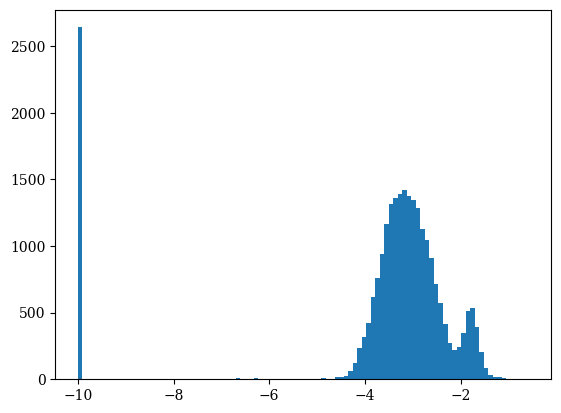

In [23]:
plt.hist(utils.to_numpy(sparsities[8]), bins=100)
plt.show()

In [24]:
live_features = np.arange(len(sparsities[8]))[utils.to_numpy(sparsities[8] > -4)]

In [25]:
live_features[:50]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36,
       37, 38, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 55])

In [24]:
feature_idx = live_features[77]
scores = get_feature_scores(model, transcoders[8], owt_tokens_torch[:128*100], feature_idx, batch_size=128, use_raw_scores=False)
display_activating_examples_dash(owt_tokens_torch, scores)

  0%|          | 0/100 [00:00<?, ?it/s]

## Input 1

In [224]:
prompt = "Oh, that rifle model is a 6M"
token_strs = model.to_str_tokens(prompt)
_, cache = model.run_with_cache(prompt)
scores = get_feature_scores(model, transcoders[8], model.tokenizer(prompt, return_tensors='pt').input_ids, feature_idx, batch_size=128, use_raw_scores=False)
scores

  0%|          | 0/1 [00:00<?, ?it/s]

array([[0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 7.516]],
      dtype=float16)

In [114]:
start_layer, end_layer = 3,8
gap_start = 2
with TranscoderReplacementContext(model, transcoders[:gap_start] + transcoders[start_layer:end_layer]):
    scores = get_feature_scores(model, transcoders[8], model.tokenizer(prompt, return_tensors='pt').input_ids, feature_idx, batch_size=128, use_raw_scores=False)
print(scores)

  0%|          | 0/1 [00:00<?, ?it/s]

[[0.   0.   0.   0.   0.   0.   0.   0.   6.26]]


In [56]:
list(enumerate(token_strs))

[(0, '<|endoftext|>'),
 (1, 'Oh'),
 (2, ','),
 (3, ' that'),
 (4, ' rifle'),
 (5, ' model'),
 (6, ' is'),
 (7, ' a'),
 (8, ' 6'),
 (9, 'M')]

In [225]:
feature_vector = make_sae_feature_vector(transcoders[8], feature_idx)

In [226]:
all_paths = greedy_get_top_paths(model, transcoders, cache, feature_vector, num_iters=4, num_branches=20, do_raw_attribution=True)

In [227]:
# ignore paths that go through MLP2 transcoder (because this transcoder is crappy)
filtered_paths = get_paths_via_filter(all_paths, not_infix_path=[
    FeatureFilter(layer=2, layer_filter_type=FilterType.EQ, feature_type=FeatureType.TRANSCODER)
])

# ignore paths that end in last token
filtered_paths = get_paths_via_filter(filtered_paths, suffix_path=[
    FeatureFilter(token=-1, token_filter_type=FilterType.NE)
])
filtered_paths = get_paths_via_filter(filtered_paths, suffix_path=[
    FeatureFilter(token=9, token_filter_type=FilterType.NE)
])

# look at paths that end in layer 0
filtered_paths = get_paths_via_filter(filtered_paths, suffix_path=[
    FeatureFilter(layer=0)
])

print_all_paths(filtered_paths)

Path [0]: mlp8tc[89]@-1 <- attn2[2]@8: 1.3 <- mlp0tc[10490]@8: 0.63
Path [1]: mlp8tc[89]@-1 <- attn2[1]@4: 0.83 <- mlp0tc[7829]@4: 0.45
Path [2]: mlp8tc[89]@-1 <- attn3[6]@8: 0.79 <- mlp0tc[10490]@8: 0.44
Path [3]: mlp8tc[89]@-1 <- attn4[11]@8: 0.97 <- mlp0tc[10490]@8: 0.37
Path [4]: mlp8tc[89]@-1 <- attn2[2]@8: 1.3 <- mlp0tc[10490]@8: 0.63 <- attn0[1]@8: 0.43
Path [5]: mlp8tc[89]@-1 <- attn2[2]@8: 1.3 <- mlp0tc[10490]@8: 0.63 <- attn0[5]@8: 0.34
Path [6]: mlp8tc[89]@-1 <- attn3[6]@8: 0.79 <- mlp0tc[10490]@8: 0.44 <- attn0[1]@8: 0.3
Path [7]: mlp8tc[89]@-1 <- mlp3tc[14171]@-1: 2.1 <- attn2[2]@8: 0.55 <- mlp0tc[10490]@8: 0.27
Path [8]: mlp8tc[89]@-1 <- attn2[2]@8: 1.3 <- mlp0tc[10490]@8: 0.63 <- embed0@8: 0.26
Path [9]: mlp8tc[89]@-1 <- attn4[11]@8: 0.97 <- mlp0tc[10490]@8: 0.37 <- attn0[1]@8: 0.25
Path [10]: mlp8tc[89]@-1 <- attn3[6]@8: 0.79 <- mlp0tc[10490]@8: 0.44 <- attn0[5]@8: 0.24
Path [11]: mlp8tc[89]@-1 <- mlp3tc[14171]@-1: 2.1 <- attn2[2]@8: 0.55 <- mlp0tc[10490]@8: 0.27 <- att

In [149]:
display_deembeddings_for_feature_vector(model, filtered_paths[15][-1])

In [203]:
for my_feature, score in get_raw_top_features_among_paths(all_paths, top_k=15, filter_layers=[0], filter_sublayers=['resid_mid']):
    print(my_feature)

mlp0tc[8829]@-1: 5.8
mlp0tc[10490]@8: 2.0
mlp0tc[4082]@-1: 0.61
mlp0tc[7829]@4: 0.45


In [101]:
display_deembeddings_for_transcoder_feature(model, transcoders[0], 7829, k=12)

In [252]:
display_deembeddings_for_transcoder_feature(model, transcoders[0], 8829, k=5)

In [255]:
# get scores
cur_scores = get_feature_scores(model, transcoders[0], owt_tokens_torch[:128*100], 10490, batch_size=128, use_raw_scores=False)
display_activating_examples_dash(owt_tokens_torch, cur_scores, header_level=None)

  0%|          | 0/100 [00:00<?, ?it/s]

## Understanding when our transcoders fail to capture feature behavior

Emperically, we can see that this feature activates far more strongly when the word "robot" is present in the context than otherwise.

In [187]:
# non-robot prompt
prompt = "  6M"
token_strs = model.to_str_tokens(prompt)
_, cache = model.run_with_cache(prompt)
scores = get_feature_scores(model, transcoders[8], model.tokenizer(prompt, return_tensors='pt').input_ids, feature_idx, batch_size=128, use_raw_scores=False)
scores # feature activation: 5.5

  0%|          | 0/1 [00:00<?, ?it/s]

array([[0. , 0. , 5.5]], dtype=float16)

In [188]:
# robot prompt
prompt = " robot 6M"
token_strs = model.to_str_tokens(prompt)
_, cache = model.run_with_cache(prompt)
scores = get_feature_scores(model, transcoders[8], model.tokenizer(prompt, return_tensors='pt').input_ids, feature_idx, batch_size=128, use_raw_scores=False)
scores # feature activation: 8.55

  0%|          | 0/1 [00:00<?, ?it/s]

array([[0.  , 0.  , 8.55]], dtype=float16)

In [151]:
list(enumerate(token_strs))

[(0, '<|endoftext|>'), (1, ' robot'), (2, ' 6'), (3, 'M')]

However, what happens if we try to find computational paths that depend on this ` robot` token?

In [189]:
all_paths = greedy_get_top_paths(model, transcoders, cache, feature_vector, num_iters=4, num_branches=20, do_raw_attribution=True)
# look at paths that end on token 1 in layer 0
filtered_paths = get_paths_via_filter(filtered_paths, suffix_path=[
    FeatureFilter(token=1, layer=0)
])
print_all_paths(filtered_paths)

Path [0]: mlp8tc[89]@-1 <- mlp3tc[14171]@-1: 2.4 <- attn2[2]@2: 0.58 <- mlp0tc[10490]@2: 0.27 <- attn0[6]@1: 0.015
Path [1]: mlp8tc[89]@-1 <- mlp3tc[14171]@-1: 2.4 <- attn2[2]@2: 0.58 <- mlp0tc[10490]@2: 0.27 <- attn0[10]@1: 0.014
Path [2]: mlp8tc[89]@-1 <- mlp3tc[14171]@-1: 2.4 <- attn2[2]@2: 0.58 <- mlp0tc[10490]@2: 0.27 <- attn0[8]@1: 0.0094
Path [3]: mlp8tc[89]@-1 <- mlp3tc[14171]@-1: 2.4 <- attn2[2]@2: 0.58 <- mlp0tc[10490]@2: 0.27 <- attn0[11]@1: 0.0051


We see barely any attribution -- and all of it is through the transcoder feature `mlp0tc[10490]@2` at token 2! Indeed, if we look at the de-embeddings for `mlp0tc[10490]@2`...

In [190]:
display_deembeddings_for_feature_vector(model, filtered_paths[0][-2])

... the transcoder feature is almost all just firing on the ` 6` token!

Why is this the case? Most likely, it's because our transcoders fail to accurately capture the behavior of the model. Indeed, we can test this by replacing some of the model's MLP layers with transcoders, and then seeing how the feature firing activation changes.

First, look at feature scores when replacing all MLPs with a transcoder.

In [191]:
with TranscoderReplacementContext(model, transcoders[:8]):
    scores = get_feature_scores(model, transcoders[8], model.tokenizer(prompt, return_tensors='pt').input_ids, feature_idx, batch_size=128, use_raw_scores=False)
print(scores)

  0%|          | 0/1 [00:00<?, ?it/s]

[[0. 0. 0.]]


The feature fails to fire at all!

What if we replace all layers' MLPs except for layers 1 and 2?

In [192]:
gap_start, gap_end = 1, 3
with TranscoderReplacementContext(model, transcoders[:gap_start] + transcoders[gap_end:8]):
    scores = get_feature_scores(model, transcoders[8], model.tokenizer(prompt, return_tensors='pt').input_ids, feature_idx, batch_size=128, use_raw_scores=False)
print(scores)

  0%|          | 0/1 [00:00<?, ?it/s]

[[0.    0.    5.637]]


The feature fires, but less. A question: is there any difference between the feature score for the "robot" prompt and the blank prompt?

In [135]:
gap_start, gap_end = 1, 3
with TranscoderReplacementContext(model, transcoders[:gap_start] + transcoders[gap_end:8]):
    scores = get_feature_scores(model, transcoders[8], model.tokenizer(["  6M", " robot 6M"], return_tensors='pt').input_ids, live_features[77], batch_size=128, use_raw_scores=False)
print(scores)

  0%|          | 0/1 [00:00<?, ?it/s]

[[0.    0.    5.117]
 [0.    0.    5.637]]


Not too much at all. It's worth noting that as we keep more and more MLP layers the same, there is a greater difference between the scores for the blank prompt and the robot prompt.

In [199]:
# only replace MLPs at layers 0, 5, 6, 7
gap_start, gap_end = 1, 5
with TranscoderReplacementContext(model, transcoders[:gap_start] + transcoders[gap_end:8]):
    scores = get_feature_scores(model, transcoders[8], model.tokenizer(["  6M", " robot 6M"], return_tensors='pt').input_ids, feature_idx, batch_size=128, use_raw_scores=False)
print(scores)

  0%|          | 0/1 [00:00<?, ?it/s]

[[0.    0.    5.375]
 [0.    0.    6.844]]


In [200]:
# only replace MLPs at layers 0, 7
gap_start, gap_end = 1, 7
with TranscoderReplacementContext(model, transcoders[:gap_start] + transcoders[gap_end:8]):
    scores = get_feature_scores(model, transcoders[8], model.tokenizer(["  6M", " robot 6M"], return_tensors='pt').input_ids, feature_idx, batch_size=128, use_raw_scores=False)
print(scores)

  0%|          | 0/1 [00:00<?, ?it/s]

[[0.    0.    5.676]
 [0.    0.    7.805]]


This suggests that the reason why we don't find any important computational paths depending on the ` robot` token is because the transcoders aren't accurate with respect to it.

# Live feature 100

In [27]:
feature_idx = live_features[100]
scores = get_feature_scores(model, transcoders[8], owt_tokens_torch[:128*100], feature_idx, batch_size=128, use_raw_scores=False)
display_activating_examples_dash(owt_tokens_torch, scores)

  0%|          | 0/100 [00:00<?, ?it/s]

In [108]:
feature_idx = live_features[100]

In [27]:
model.tokenizer.decode(owt_tokens_torch[2924, 60:62])

'’'

In [109]:
prompt = "This will drastically increase the island nation’s"
token_strs = model.to_str_tokens(prompt)
_, cache = model.run_with_cache(prompt)
scores = get_feature_scores(model, transcoders[8], model.tokenizer(prompt, return_tensors='pt').input_ids, feature_idx, batch_size=128, use_raw_scores=False)
scores

  0%|          | 0/1 [00:00<?, ?it/s]

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 6.57]],
      dtype=float16)

In [91]:
with TranscoderReplacementContext(model, transcoders[:8]):
    scores = get_feature_scores(model, transcoders[8], model.tokenizer(prompt, return_tensors='pt').input_ids, feature_idx, batch_size=128, use_raw_scores=False)
print(scores)

  0%|          | 0/1 [00:00<?, ?it/s]

[[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.7393]]


In [132]:
replacement_scores = []
for i in range(8):
    with TranscoderReplacementContext(model, [transcoders[i]]):
        scores = get_feature_scores(model, transcoders[8], model.tokenizer(prompt, return_tensors='pt').input_ids, feature_idx, batch_size=128, use_raw_scores=False)
        replacement_scores.append(scores[0][-1])
print(replacement_scores)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[5.81, 6.406, 6.934, 6.527, 6.12, 5.82, 6.438, 5.92]


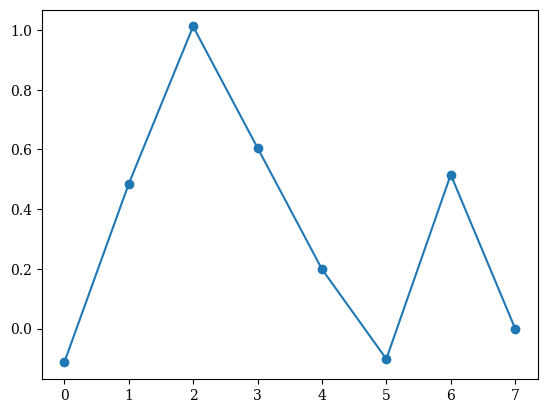

In [133]:
plt.plot(replacement_scores-scores[0,-1], marker='o')

In [32]:
start_layer, end_layer = 6,8
gap_start = 0
with TranscoderReplacementContext(model, transcoders[:gap_start] + transcoders[start_layer:end_layer]):
    scores = get_feature_scores(model, transcoders[8], model.tokenizer(prompt, return_tensors='pt').input_ids, feature_idx, batch_size=128, use_raw_scores=False)
print(scores)

  0%|          | 0/1 [00:00<?, ?it/s]

[[0.   0.   0.   0.   0.   0.   0.   0.   0.   6.12]]


In [33]:
list(enumerate(token_strs))

[(0, '<|endoftext|>'),
 (1, 'This'),
 (2, ' will'),
 (3, ' drastically'),
 (4, ' increase'),
 (5, ' the'),
 (6, ' island'),
 (7, ' nation'),
 (8, '�'),
 (9, '�'),
 (10, 's')]

In [34]:
feature_vector = make_sae_feature_vector(transcoders[8], feature_idx)

In [110]:
all_paths = greedy_get_top_paths(model, transcoders, cache, feature_vector, num_iters=4, num_branches=20, do_raw_attribution=True)

In [111]:
print_all_paths(all_paths)

--- Paths of size 2 ---
Path [0][0]: mlp8tc[115]@-1 <- attn8[7]@4: 4.1
Path [0][1]: mlp8tc[115]@-1 <- mlp7tc[10937]@-1: 2.5
Path [0][2]: mlp8tc[115]@-1 <- attn6[11]@4: 2.5
Path [0][3]: mlp8tc[115]@-1 <- attn7[0]@4: 2.3
Path [0][4]: mlp8tc[115]@-1 <- attn5[2]@8: 1.8
Path [0][5]: mlp8tc[115]@-1 <- attn7[0]@5: 1.5
Path [0][6]: mlp8tc[115]@-1 <- attn6[11]@5: 1.5
Path [0][7]: mlp8tc[115]@-1 <- attn8[7]@5: 1.4
Path [0][8]: mlp8tc[115]@-1 <- attn6[0]@7: 1.3
Path [0][9]: mlp8tc[115]@-1 <- attn4[3]@7: 1.1
Path [0][10]: mlp8tc[115]@-1 <- mlp6tc[2475]@-1: 1.0
Path [0][11]: mlp8tc[115]@-1 <- attn8[5]@3: 1.0
Path [0][12]: mlp8tc[115]@-1 <- mlp4tc[3725]@-1: 0.96
Path [0][13]: mlp8tc[115]@-1 <- mlp6tc[1476]@-1: 0.87
Path [0][14]: mlp8tc[115]@-1 <- attn6[0]@6: 0.87
Path [0][15]: mlp8tc[115]@-1 <- mlp7tc[24527]@-1: 0.85
Path [0][16]: mlp8tc[115]@-1 <- attn0[5]@10: 0.85
Path [0][17]: mlp8tc[115]@-1 <- embed0@-1: 0.8
Path [0][18]: mlp8tc[115]@-1 <- mlp0tc[17755]@-1: 0.74
Path [0][19]: mlp8tc[115]@-1 <- a

In [118]:
filtered_paths = get_paths_via_filter(all_paths, suffix_path=[
    FeatureFilter(token=7),
])

print_all_paths(filtered_paths)

Path [0]: mlp8tc[115]@-1 <- attn6[0]@7: 1.3
Path [1]: mlp8tc[115]@-1 <- attn4[3]@7: 1.1
Path [2]: mlp8tc[115]@-1 <- attn4[3]@7: 1.1 <- mlp0tc[16299]@7: 0.45
Path [3]: mlp8tc[115]@-1 <- attn6[0]@7: 1.3 <- mlp0tc[16299]@7: 0.35
Path [4]: mlp8tc[115]@-1 <- mlp6tc[2475]@-1: 1.0 <- attn4[3]@7: 0.29
Path [5]: mlp8tc[115]@-1 <- attn4[3]@7: 1.1 <- mlp0tc[16299]@7: 0.45 <- attn0[5]@7: 0.26
Path [6]: mlp8tc[115]@-1 <- attn6[0]@7: 1.3 <- mlp0tc[16299]@7: 0.35 <- attn0[5]@7: 0.2
Path [7]: mlp8tc[115]@-1 <- attn4[3]@7: 1.1 <- mlp0tc[16299]@7: 0.45 <- attn0[1]@7: 0.2
Path [8]: mlp8tc[115]@-1 <- attn6[0]@7: 1.3 <- mlp0tc[16299]@7: 0.35 <- attn0[1]@7: 0.15
Path [9]: mlp8tc[115]@-1 <- attn4[3]@7: 1.1 <- mlp0tc[16299]@7: 0.45 <- embed0@7: 0.14


In [122]:
display_deembeddings_for_feature_vector(model, filtered_paths[5][-1])

In [123]:
filtered_paths = get_paths_via_filter(all_paths, suffix_path=[
    FeatureFilter(layer=0, component_type=ComponentType.MLP),
    FeatureFilter(layer=0, component_type=ComponentType.ATTN),
])

print_all_paths(filtered_paths)

Path [0]: mlp8tc[115]@-1 <- mlp0tc[17755]@-1: 0.74 <- attn0[1]@10: 0.44
Path [1]: mlp8tc[115]@-1 <- mlp0tc[17755]@-1: 0.74 <- attn0[5]@10: 0.31
Path [2]: mlp8tc[115]@-1 <- mlp6tc[2475]@-1: 1.0 <- mlp0tc[17755]@-1: 0.47 <- attn0[1]@10: 0.28
Path [3]: mlp8tc[115]@-1 <- mlp6tc[1476]@-1: 0.87 <- mlp0tc[17755]@-1: 0.47 <- attn0[1]@10: 0.28
Path [4]: mlp8tc[115]@-1 <- attn4[3]@7: 1.1 <- mlp0tc[16299]@7: 0.45 <- attn0[5]@7: 0.26
Path [5]: mlp8tc[115]@-1 <- attn6[0]@7: 1.3 <- mlp0tc[16299]@7: 0.35 <- attn0[5]@7: 0.2
Path [6]: mlp8tc[115]@-1 <- attn4[3]@7: 1.1 <- mlp0tc[16299]@7: 0.45 <- attn0[1]@7: 0.2
Path [7]: mlp8tc[115]@-1 <- mlp6tc[2475]@-1: 1.0 <- mlp0tc[17755]@-1: 0.47 <- attn0[5]@10: 0.2
Path [8]: mlp8tc[115]@-1 <- mlp6tc[1476]@-1: 0.87 <- mlp0tc[17755]@-1: 0.47 <- attn0[5]@10: 0.2
Path [9]: mlp8tc[115]@-1 <- attn6[11]@4: 2.5 <- mlp0tc[3702]@4: 0.54 <- attn0[5]@4: 0.18
Path [10]: mlp8tc[115]@-1 <- attn6[11]@4: 2.5 <- mlp0tc[3702]@4: 0.54 <- attn0[3]@4: 0.17
Path [11]: mlp8tc[115]@-1 <-

In [36]:
# look at paths that don't terminate in token 10 (the final token)
filtered_paths = get_paths_via_filter(all_paths, suffix_path=[
    FeatureFilter(layer=0, token=10, token_filter_type=FilterType.NE)
])

filtered_paths = get_paths_via_filter(filtered_paths, suffix_path=[
    FeatureFilter(layer=0, token=-1, token_filter_type=FilterType.NE)
])

print_all_paths(filtered_paths)

Path [0]: mlp8tc[115]@-1 <- attn6[11]@4: 2.5 <- mlp0tc[3702]@4: 0.54
Path [1]: mlp8tc[115]@-1 <- attn4[3]@7: 1.1 <- mlp0tc[16299]@7: 0.45
Path [2]: mlp8tc[115]@-1 <- attn6[0]@7: 1.3 <- mlp0tc[16299]@7: 0.35
Path [3]: mlp8tc[115]@-1 <- attn6[11]@4: 2.5 <- mlp0tc[3702]@4: 0.54 <- embed0@4: 0.27
Path [4]: mlp8tc[115]@-1 <- attn4[3]@7: 1.1 <- mlp0tc[16299]@7: 0.45 <- attn0[5]@7: 0.26
Path [5]: mlp8tc[115]@-1 <- attn5[2]@8: 1.8 <- attn2[8]@4: 0.42 <- mlp0tc[3702]@4: 0.21
Path [6]: mlp8tc[115]@-1 <- attn6[0]@7: 1.3 <- mlp0tc[16299]@7: 0.35 <- attn0[5]@7: 0.2
Path [7]: mlp8tc[115]@-1 <- attn4[3]@7: 1.1 <- mlp0tc[16299]@7: 0.45 <- attn0[1]@7: 0.2
Path [8]: mlp8tc[115]@-1 <- attn6[11]@4: 2.5 <- mlp0tc[3702]@4: 0.54 <- attn0[5]@4: 0.18
Path [9]: mlp8tc[115]@-1 <- attn6[11]@4: 2.5 <- mlp0tc[3702]@4: 0.54 <- attn0[3]@4: 0.17
Path [10]: mlp8tc[115]@-1 <- attn6[0]@7: 1.3 <- mlp0tc[16299]@7: 0.35 <- attn0[1]@7: 0.15
Path [11]: mlp8tc[115]@-1 <- attn8[7]@4: 4.1 <- mlp7tc[21500]@4: 0.33 <- mlp0tc[3702]

In [37]:
display_deembeddings_for_feature_vector(model, filtered_paths[0][-1])

In [38]:
display_deembeddings_for_feature_vector(model, filtered_paths[1][-1])

## Turning paths into graphs

In [138]:
plot_paths(filtered_paths)

# Blind feature case study!

In [140]:
feature_idx = live_features[200]
my_feature = make_sae_feature_vector(transcoders[8], feature_idx, use_encoder=True, token=-1)
print(my_feature)

mlp8tc[235]@-1


In [141]:
# get scores
scores = get_feature_scores(model, transcoders[8], owt_tokens_torch[:128*100], feature_idx, batch_size=128, use_raw_scores=False)
uniform_samples = sample_uniform(scores, num_samples=50)

  0%|          | 0/100 [00:00<?, ?it/s]

In [142]:
uniform_scores, uniform_idxs = uniform_samples[0], uniform_samples[1]
print(uniform_scores)

[ 0.      0.4524  0.9155  1.369   1.837   2.318   2.746   3.064   3.65
  4.14    4.58    5.06    5.414   5.965   6.156   6.66    7.348   7.85
  8.68   10.414  10.664  11.77   12.6    12.83   13.12   13.96   14.98
 15.55   15.766  16.45   17.14   17.44   17.73   18.36   18.75   19.38
 19.64   20.17   20.64   21.19   21.4    21.88   22.4   ]


In [144]:
threshold = 17.0
uniform_idxs = uniform_idxs[uniform_scores>threshold]
uniform_scores = uniform_scores[uniform_scores>threshold]
print(uniform_idxs)

[[ 9687   105]
 [  837    13]
 [ 1399   123]
 [11713    34]
 [ 4644    86]
 [ 6801    70]
 [ 1417    46]
 [  817    63]
 [ 8531   111]
 [  755    73]
 [ 6299    39]
 [ 1077   112]
 [11390    41]]


## Input 8531, 111

In [145]:
prompt = owt_tokens_torch[8531, :111+1]
_, cache = model.run_with_cache(prompt)

In [147]:
all_paths = greedy_get_top_paths(model, transcoders, cache, my_feature, num_iters=5, num_branches=15)
print_all_paths(all_paths)

--- Paths of size 2 ---
Path [0][0]: mlp8tc[235]@-1 <- mlp7tc[14382]@-1: 2.1e+01
Path [0][1]: mlp8tc[235]@-1 <- mlp0tc[1636]@-1: 1.5e+01
Path [0][2]: mlp8tc[235]@-1 <- mlp6tc[22733]@-1: 7.9
Path [0][3]: mlp8tc[235]@-1 <- mlp3tc[7628]@-1: 6.9
Path [0][4]: mlp8tc[235]@-1 <- mlp5tc[11575]@-1: 5.7
Path [0][5]: mlp8tc[235]@-1 <- mlp4tc[21770]@-1: 5.6
Path [0][6]: mlp8tc[235]@-1 <- mlp2tc[17511]@-1: 4.8
Path [0][7]: mlp8tc[235]@-1 <- mlp1tc[4598]@-1: 4.4
Path [0][8]: mlp8tc[235]@-1 <- attn5[7]@111: 3.6
Path [0][9]: mlp8tc[235]@-1 <- attn0[4]@111: 2.5
Path [0][10]: mlp8tc[235]@-1 <- attn0[1]@111: 2.2
Path [0][11]: mlp8tc[235]@-1 <- attn0[5]@111: 1.6
Path [0][12]: mlp8tc[235]@-1 <- mlp7tc[760]@-1: 1.4
Path [0][13]: mlp8tc[235]@-1 <- attn8[4]@111: 1.4
Path [0][14]: mlp8tc[235]@-1 <- embed0@-1: 1.3
--- Paths of size 3 ---
Path [1][0]: mlp8tc[235]@-1 <- mlp0tc[1636]@-1: 1.5e+01 <- attn0[1]@111: 6.1
Path [1][1]: mlp8tc[235]@-1 <- mlp0tc[1636]@-1: 1.5e+01 <- attn0[4]@111: 5.6
Path [1][2]: mlp8tc[23

Looks like almost all of our importance comes from the final token in the input. 

### Input-independent information

Let's look at `mlp7tc[14382]@-1`. Which MLP0 transcoder features is it -- input-indepedently -- most connected to?

In [153]:
cur_feature = all_paths[2][1][1]
print(cur_feature)

mlp7tc[14382]@-1: 2.1e+01


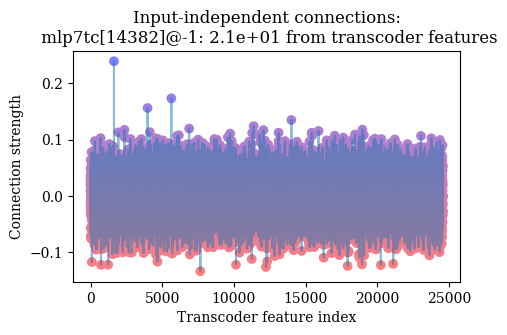

In [160]:
display_transcoder_pullback_features(model, cur_feature, transcoders[0])

In [161]:
display_deembeddings_for_transcoder_feature(model, transcoders[0], 1636, k=2)

In [162]:
display_deembeddings_for_transcoder_feature(model, transcoders[0], 5637, k=2)

In [163]:
display_deembeddings_for_transcoder_feature(model, transcoders[0], 3981, k=2)

In [166]:
display_deembeddings_for_transcoder_feature(model, transcoders[0], 14013, k=5)

In [165]:
display_deembeddings_for_transcoder_feature(model, transcoders[0], 11383, k=2)

*Current hypothesis*: feature fires on forms of the verb "catch", "captured". Probably news articles about criminals?

## Input 6299, 39

In [171]:
prompt = owt_tokens_torch[6299, :39+1]
_, cache = model.run_with_cache(prompt)

In [172]:
all_paths = greedy_get_top_paths(model, transcoders, cache, my_feature, num_iters=5, num_branches=15)
print_all_paths(all_paths)

--- Paths of size 2 ---
Path [0][0]: mlp8tc[235]@-1 <- mlp7tc[14382]@-1: 2.2e+01
Path [0][1]: mlp8tc[235]@-1 <- mlp0tc[1636]@-1: 1.7e+01
Path [0][2]: mlp8tc[235]@-1 <- mlp6tc[22733]@-1: 8.3
Path [0][3]: mlp8tc[235]@-1 <- mlp3tc[7628]@-1: 7.1
Path [0][4]: mlp8tc[235]@-1 <- mlp5tc[11575]@-1: 6.3
Path [0][5]: mlp8tc[235]@-1 <- mlp4tc[21770]@-1: 6.0
Path [0][6]: mlp8tc[235]@-1 <- mlp2tc[17511]@-1: 4.8
Path [0][7]: mlp8tc[235]@-1 <- mlp1tc[4598]@-1: 4.6
Path [0][8]: mlp8tc[235]@-1 <- attn8[4]@39: 3.0
Path [0][9]: mlp8tc[235]@-1 <- attn0[4]@39: 2.4
Path [0][10]: mlp8tc[235]@-1 <- attn5[7]@39: 2.3
Path [0][11]: mlp8tc[235]@-1 <- attn0[1]@39: 2.0
Path [0][12]: mlp8tc[235]@-1 <- attn0[5]@39: 1.6
Path [0][13]: mlp8tc[235]@-1 <- mlp2tc[6202]@-1: 1.6
Path [0][14]: mlp8tc[235]@-1 <- mlp7tc[18519]@-1: 1.4
--- Paths of size 3 ---
Path [1][0]: mlp8tc[235]@-1 <- mlp0tc[1636]@-1: 1.7e+01 <- embed0@-1: 6.1
Path [1][1]: mlp8tc[235]@-1 <- mlp7tc[14382]@-1: 2.2e+01 <- mlp0tc[1636]@-1: 5.9
Path [1][2]: mlp8t

Again, almost all computational paths depend on last token; again, `mlp7tc[14382]` and `mlp0tc[1636]` are the main players.

## Input 817, 63

In [173]:
prompt = owt_tokens_torch[817, :63+1]
_, cache = model.run_with_cache(prompt)

In [174]:
all_paths = greedy_get_top_paths(model, transcoders, cache, my_feature, num_iters=5, num_branches=15)
print_all_paths(all_paths)

--- Paths of size 2 ---
Path [0][0]: mlp8tc[235]@-1 <- mlp7tc[14382]@-1: 1.8e+01
Path [0][1]: mlp8tc[235]@-1 <- mlp0tc[1636]@-1: 1.6e+01
Path [0][2]: mlp8tc[235]@-1 <- mlp6tc[22733]@-1: 6.4
Path [0][3]: mlp8tc[235]@-1 <- mlp3tc[7628]@-1: 6.1
Path [0][4]: mlp8tc[235]@-1 <- mlp5tc[11575]@-1: 4.4
Path [0][5]: mlp8tc[235]@-1 <- mlp4tc[21770]@-1: 4.3
Path [0][6]: mlp8tc[235]@-1 <- mlp2tc[17511]@-1: 4.0
Path [0][7]: mlp8tc[235]@-1 <- mlp1tc[4598]@-1: 4.0
Path [0][8]: mlp8tc[235]@-1 <- attn8[4]@63: 2.7
Path [0][9]: mlp8tc[235]@-1 <- attn0[4]@63: 2.4
Path [0][10]: mlp8tc[235]@-1 <- attn0[1]@63: 2.1
Path [0][11]: mlp8tc[235]@-1 <- attn0[5]@63: 1.6
Path [0][12]: mlp8tc[235]@-1 <- attn1[0]@62: 1.4
Path [0][13]: mlp8tc[235]@-1 <- mlp7tc[18519]@-1: 1.3
Path [0][14]: mlp8tc[235]@-1 <- mlp7tc[23744]@-1: 1.3
--- Paths of size 3 ---
Path [1][0]: mlp8tc[235]@-1 <- mlp0tc[1636]@-1: 1.6e+01 <- embed0@-1: 5.7
Path [1][1]: mlp8tc[235]@-1 <- mlp0tc[1636]@-1: 1.6e+01 <- attn0[1]@63: 5.7
Path [1][2]: mlp8tc[23

Same pattern as before.

## Moment of truth: confirming/denying our hypothesis

**Final hypothesis**: largely single-token feature that fires on "caught", "captured", "uncovered", and similar (particularly past-tense) forms of the verb "to catch".

In [175]:
display_activating_examples_dash(owt_tokens_torch[:128*100], scores)

**How'd we do?** We were correct about "caught". However, the other similar verbs (like "captured" and "uncovered") weren't present in the top-activating examples.

Also, it seems that in all the top-activating examples, "caught" is used as a participle, rather than as the past tense of the verb "catch". (E.g. you don't really see any examples like "I caught him!". Is this an important factor for the original feature? 

## Post-mortem: "caught" as participle versus finite verb

In [177]:
test_prompt = "He was caught"
scores = get_feature_scores(model, transcoders[8], model.tokenizer(test_prompt, return_tensors='pt').input_ids, feature_idx, batch_size=128, use_raw_scores=False)
scores

  0%|          | 0/1 [00:00<?, ?it/s]

array([[ 0.  ,  0.  , 19.97]], dtype=float16)

In [183]:
test_prompt = "He caught the ball"
scores = get_feature_scores(model, transcoders[8], model.tokenizer(test_prompt, return_tensors='pt').input_ids, feature_idx, batch_size=128, use_raw_scores=False)
scores

  0%|          | 0/1 [00:00<?, ?it/s]

array([[0.    , 0.8145, 0.    , 0.    ]], dtype=float16)

Yep! This is in fact important!

But why didn't this show up in our computational paths?

In [179]:
test_prompt = "He was caught"
with TranscoderReplacementContext(model, transcoders[:8]):
    scores = get_feature_scores(model, transcoders[8], model.tokenizer(test_prompt, return_tensors='pt').input_ids, feature_idx, batch_size=128, use_raw_scores=False)
print(scores)

  0%|          | 0/1 [00:00<?, ?it/s]

[[ 0.    0.   16.45]]


In [182]:
test_prompt = "He caught the ball"
with TranscoderReplacementContext(model, transcoders[:8]):
    scores = get_feature_scores(model, transcoders[8], model.tokenizer(test_prompt, return_tensors='pt').input_ids, feature_idx, batch_size=128, use_raw_scores=False)
print(scores)

  0%|          | 0/1 [00:00<?, ?it/s]

[[0. 9. 0. 0.]]


Looks like our transcoders don't do a great job of modeling this subtle contextual difference between "caught" as an active verb and "caught" as a past participle.

### Filtering for computational paths

In [187]:
test_prompt = "He was caught"
print(model.to_str_tokens(test_prompt))
_, cache = model.run_with_cache(test_prompt)

['<|endoftext|>', 'He', ' was', ' caught']


In [198]:
all_paths = greedy_get_top_paths(model, transcoders, cache, my_feature, num_iters=5, num_branches=30, do_raw_attribution=True)

In [199]:
# ignore paths that go through MLP2 transcoder (because this transcoder is crappy)
filtered_paths = get_paths_via_filter(all_paths, suffix_path=[
    FeatureFilter(token=2)
])

print_all_paths(filtered_paths)

Path [0]: mlp8tc[235]@-1 <- attn1[0]@2: 1.1
Path [1]: mlp8tc[235]@-1 <- attn3[2]@2: 0.7


In [200]:
subcircuit = greedy_get_top_paths(model, transcoders, cache, filtered_paths[0][-1], num_iters=1, num_branches=10, do_raw_attribution=True)
print_all_paths(subcircuit)

--- Paths of size 2 ---
Path [0][0]: attn1[0]@2: 1.1 <- mlp0tc[15269]@2: 0.6
Path [0][1]: attn1[0]@2: 1.1 <- mlp0tc[24399]@2: 0.22
Path [0][2]: attn1[0]@2: 1.1 <- mlp0tc[6036]@2: 0.13
Path [0][3]: attn1[0]@2: 1.1 <- mlp0tc[10177]@2: 0.1
Path [0][4]: attn1[0]@2: 1.1 <- attn0[1]@2: 0.061
Path [0][5]: attn1[0]@2: 1.1 <- attn0[7]@1: 0.039
Path [0][6]: attn1[0]@2: 1.1 <- attn0[9]@1: 0.036
Path [0][7]: attn1[0]@2: 1.1 <- attn0[9]@2: 0.028
Path [0][8]: attn1[0]@2: 1.1 <- attn0[7]@2: 0.026
Path [0][9]: attn1[0]@2: 1.1 <- attn0[8]@2: 0.025


In [201]:
display_deembeddings_for_feature_vector(model, subcircuit[0][0][-1])
display_deembeddings_for_feature_vector(model, subcircuit[0][1][-1])
display_deembeddings_for_feature_vector(model, subcircuit[0][2][-1])

In [202]:
subcircuit = greedy_get_top_paths(model, transcoders, cache, filtered_paths[1][-1], num_iters=1, num_branches=10, do_raw_attribution=True)
print_all_paths(subcircuit)

--- Paths of size 2 ---
Path [0][0]: attn3[2]@2: 0.7 <- mlp0tc[15269]@2: 0.26
Path [0][1]: attn3[2]@2: 0.7 <- mlp0tc[24399]@2: 0.12
Path [0][2]: attn3[2]@2: 0.7 <- attn0[1]@2: 0.11
Path [0][3]: attn3[2]@2: 0.7 <- mlp0tc[10177]@2: 0.1
Path [0][4]: attn3[2]@2: 0.7 <- mlp1tc[1422]@2: 0.085
Path [0][5]: attn3[2]@2: 0.7 <- attn1[10]@2: 0.063
Path [0][6]: attn3[2]@2: 0.7 <- attn1[10]@1: 0.051
Path [0][7]: attn3[2]@2: 0.7 <- attn2[3]@1: 0.049
Path [0][8]: attn3[2]@2: 0.7 <- mlp0tc[6036]@2: 0.048
Path [0][9]: attn3[2]@2: 0.7 <- mlp1tc[15836]@2: 0.045


So we do see some mild attribution to transcoder features that fire on "was". But why are these attribution scores so low compared to the striking difference in feature activation when "was" is present versus when it's absent?

Possible answers:
* Bug in circuit code? I'll have to take another look
* Negative attributions? Maybe, instead of "was" positively promoting the feature, it's instead the case that tokens that aren't "was" negatively promote the feature. Again, I'll have to take another look.

## Just for kicks: plot all paths

In [231]:
prompt = owt_tokens_torch[817, :63+1]
_, cache = model.run_with_cache(prompt)
all_paths = greedy_get_top_paths(model, transcoders, cache, my_feature, num_iters=5, num_branches=15, do_raw_attribution=True)

In [244]:
plot_paths(all_paths)

**Question:** in the graph, there is only one incoming edge to `mlp5tc[11575]@-1`. This edge has a contrib value of 2.7. However, `mlp5tc[11575]@-1` has a contrib value of 4.4. What's the reason for this discrepancy?

**Answer:** `all_paths`, the collection of paths that we used to make this graph, is the result of running what is essentially greedy BFS on the graph of computational paths. The most important computational paths are kept, and less-important paths are pruned. In this case, some of the paths that contributed to `mlp5tc[11575]@-1`'s score of 4.4 ended up not making it into the graph.